# Imports

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 #opencv pour SIFT


pd.options.display.max_rows = 999

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from keras.preprocessing.image import load_img, img_to_array
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation
from keras.models import clone_model

from ipywidgets import IntProgress
from ipywidgets import Text
from IPython.display import display
from IPython.display import Image

from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL

import time

# Préparation données

In [32]:
data = pd.read_csv('data_saved/data_categories.csv')

In [33]:
train = pd.read_csv('data_saved/train.csv')
test = pd.read_csv('data_saved/test.csv')

In [34]:
def get_files(path_list):
    '''Renvoie la liste des matrices d\'images à partir d'une liste de chemins'''
    liste_image = []
    compteur = 0
    for image_path in path_list:
        #im = cv2.imread(image_path, 0)
        im = np.array(Image_PIL.open(image_path))
        liste_image.append(im)
        compteur +=1
    
    del compteur
    del im
    
    return liste_image

In [35]:
def redim(array_im, width, height):
    '''Redimensionne l\'image correspondant à array_im dans la largeur et la hauteur définie'''
    min_x = 100000
    max_x = 0
    min_y = 100000
    max_y = 0
    shape = array_im.shape
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]
    im = cv2.resize(array_im, dsize=(width,height))
    
    del shape
    
    return im

In [36]:
if False:
    train['image'] = train['image'].apply(lambda x: 'data/Images/'+str(x))
    test['image'] = test['image'].apply(lambda x: 'data/Images/'+str(x))

    train_cnn = get_files(train.copy()['image'].tolist())
    test_cnn = get_files(test.copy()['image'].tolist())

    train_array_cnn = np.vstack([redim(img, 224, 224).reshape(1,224,224,3) for img in train_cnn])
    test_array_cnn = np.vstack([redim(img, 224, 224).reshape(1,224,224,3) for img in test_cnn])
    del train_cnn, test_cnn
    #sauvegarde train_array_ccn / test_array_cnn
    np.save('data_saved/train_images_array', train_array_cnn)
    np.save('data_saved/test_images_array', test_array_cnn)
else:
    train_array_cnn = np.load('data_saved/train_images_array.npy')
    test_array_cnn = np.load('data_saved/test_images_array.npy')
    

In [37]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
array_cats = ohe.fit_transform(np.array(train['cat_lvl_2']).reshape(-1,1))

In [38]:
array_cats.todense().shape

(787, 57)

In [39]:
train_array_cats = ohe.transform(train[['cat_lvl_2']]).todense()
test_array_cats = ohe.transform(test[['cat_lvl_2']]).todense()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [40]:
train_array_cats.shape

(787, 57)

In [41]:
test_array_cats.shape

(263, 57)

In [42]:
ohe.categories_[0].shape[0]

57

# Transfer Learning VGG16 Imagenet

In [43]:
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
vgg = VGG16()
vgg.layers.pop()
vgg.layers.pop()

vgg_transfer = Sequential()
vgg_transfer.add(vgg)
vgg_transfer.trainable = False
vgg_transfer.add(Dense(ohe.categories_[0].shape[0], activation='softmax'))
vgg_transfer.compile(loss='mean_squared_error', optimizer='sgd')


In [44]:
print('train array shape : ', train_array_cnn.shape)
print('train array cats : ', train_array_cats.shape)


train array shape :  (787, 224, 224, 3)
train array cats :  (787, 57)


In [45]:
vgg_transfer.fit(train_array_cnn, train_array_cats, epochs=3, batch_size=20, verbose=1)

Epoch 1/3
40/40 [==============================] - 97s 2s/step - loss: 0.0172
Epoch 2/3
40/40 [==============================] - 98s 2s/step - loss: 0.0172
Epoch 3/3
40/40 [==============================] - 101s 3s/step - loss: 0.0172


In [46]:
vgg_transfer.save_weights('models/weighs_vgg_transfer.weights')

In [47]:
vgg_transfer.load_weights('models/weighs_vgg_transfer.weights')

In [48]:
train.iloc[36]

Unnamed: 0                                                                82
uniq_id                                     601817defaff9d0e30e1b72f96d3975f
crawl_timestamp                                    2016-03-10 07:45:58 +0000
product_url                http://www.flipkart.com/chinmay-kids-printed-c...
product_name                 CHINMAY KIDS Printed Cotton Padded Mosquito Net
pid                                                         MNTEGKSZD2ZWUBZK
retail_price                                                          1490.0
discounted_price                                                       540.0
image                                   601817defaff9d0e30e1b72f96d3975f.jpg
is_FK_Advantage_product                                                False
description                Specifications of CHINMAY KIDS Printed Cotton ...
product_rating                                           No rating available
overall_rating                                           No rating available

1/1 [==============================] - 0s 332ms/step


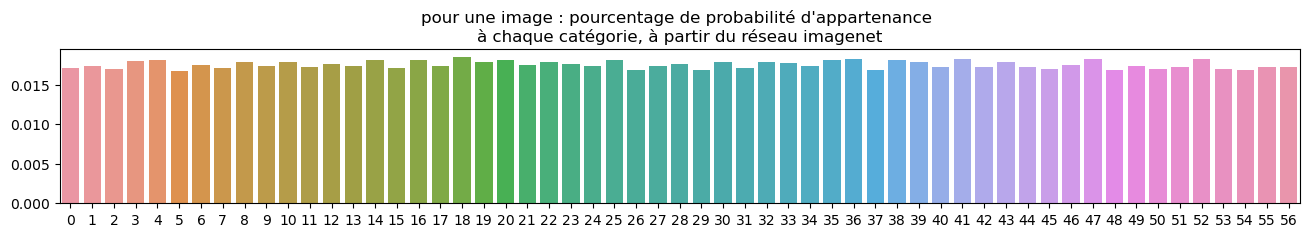

1/1 [==============================] - 0s 192ms/step


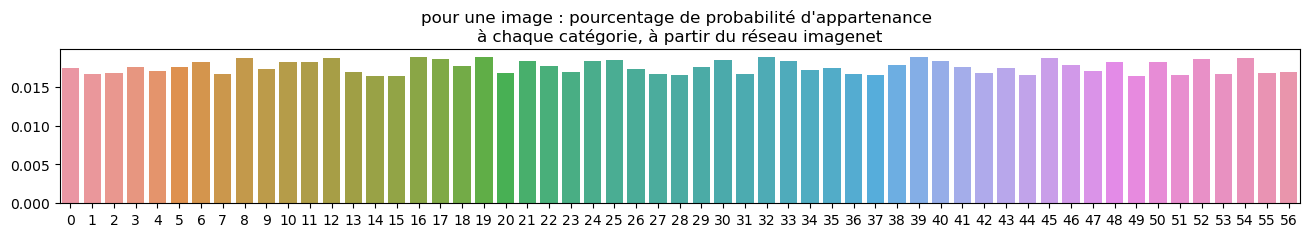

1/1 [==============================] - 0s 192ms/step


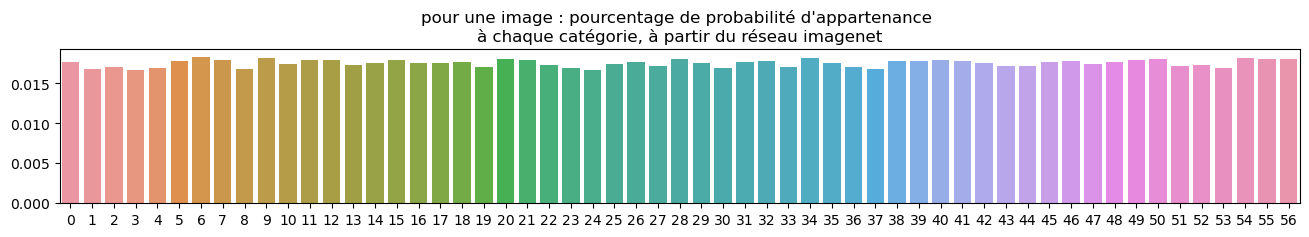

In [49]:
%matplotlib inline
ex_prediction_vgg = vgg_transfer.predict(redim(test_array_cnn[24], 224, 224).reshape(1,224,224,3))
plt.figure(figsize=(16,2))
plt.title('pour une image : pourcentage de probabilité d\'appartenance \nà chaque catégorie, à partir du réseau imagenet')
sns.barplot(x = list(range(ex_prediction_vgg.shape[1])), 
            y = ex_prediction_vgg[0])
plt.show()
ex_prediction_vgg = vgg_transfer.predict(redim(test_array_cnn[28], 224, 224).reshape(1,224,224,3))
plt.figure(figsize=(16,2))
plt.title('pour une image : pourcentage de probabilité d\'appartenance \nà chaque catégorie, à partir du réseau imagenet')
sns.barplot(x = list(range(ex_prediction_vgg.shape[1])), 
            y = ex_prediction_vgg[0])
plt.show()
ex_prediction_vgg = vgg_transfer.predict(redim(test_array_cnn[36], 224, 224).reshape(1,224,224,3))
plt.figure(figsize=(16,2))
plt.title('pour une image : pourcentage de probabilité d\'appartenance \nà chaque catégorie, à partir du réseau imagenet')
sns.barplot(x = list(range(ex_prediction_vgg.shape[1])), 
            y = ex_prediction_vgg[0])
plt.show()

In [50]:
vgg_train_output = vgg_transfer.predict(train_array_cnn)
vgg_test_output = vgg_transfer.predict(test_array_cnn)

9/9 [==============================] - 33s 4s/step


In [51]:
vgg_train_output.shape

(787, 57)

In [52]:
vgg_test_output.shape

(263, 57)

In [53]:
vgg_output = np.vstack([vgg_train_output, vgg_test_output])

In [54]:
vgg_output.shape

(1050, 57)

In [55]:
np.save('data_saved/transfer_learning_output', vgg_output)

# Approche combinée

## Données

In [56]:
X_NLP = np.load('data_saved/X_reduce_NLP.csv.npy')
X_descripteurs = np.load('data_saved/array_features_descripteurs.npy')
X_CNN = np.load('data_saved/transfer_learning_output.npy')

In [57]:
X_NLP.shape

(1050, 392)

In [58]:
np.vstack([np.array(train['discounted_price']).reshape(-1,1),
           np.array(test['discounted_price']).reshape(-1,1)])

array([[  349.],
       [ 5436.],
       [13500.],
       ...,
       [  356.],
       [  550.],
       [  950.]])

In [59]:
np.array(data['discounted_price']).reshape(-1,1).shape[1]

1

## Homogénisation des dimensions

In [60]:
print('NLP : ', X_NLP.shape)
print('Descripteurs : ', X_descripteurs.T.shape)
print('CNN : ', X_CNN.shape)

NLP :  (1050, 392)
Descripteurs :  (1050, 6)
CNN :  (1050, 57)


on a 651 dimensions pour la partie textuelle et 63 pour la partie visuelle

## Assemblage des données

In [61]:
X_combined = np.hstack([np.array(data['discounted_price']).reshape(-1,1), 
           X_NLP,
           X_CNN, 
           X_descripteurs.T])

In [62]:
X_combined.shape

(1050, 456)

In [63]:
np.nan_to_num(X_combined, 0)

array([[ 8.99000000e+02, -5.19453864e-02,  2.91818774e-01, ...,
         1.14198085e-02,  5.56996849e-04,  6.50072121e-04],
       [ 4.49000000e+02, -1.06193267e+00, -1.02189407e+00, ...,
         1.16043119e-02,  2.06271259e-04,  6.10492483e-04],
       [ 0.00000000e+00, -1.42603611e+00, -1.39605216e+00, ...,
         1.32497549e-02,  1.17549510e-03,  8.08824319e-04],
       ...,
       [ 1.44900000e+03, -6.30739191e-01, -5.81291690e-01, ...,
         1.10470587e-02,  5.08179539e-04,  5.45304443e-04],
       [ 1.33300000e+03, -1.27730138e+00, -1.16353661e+00, ...,
         1.16347419e-02,  7.39649695e-04,  5.98189072e-04],
       [ 5.95000000e+02, -1.32434382e+00, -1.27791739e+00, ...,
         1.10336356e-02,  2.84803449e-04,  5.70441422e-04]])

In [64]:
np.save('data_saved/X_combined', X_combined)

In [65]:
X_combined = np.load('data_saved/X_combined.npy')

## Catégorisation

In [67]:
dict_kmeans = {}
inertia = {}
max_clusters=80

f = IntProgress(min=0, max=max_clusters) # instantiate the bar
g = Text(value='')
display(f) # display the bar
display(g)

for k in range(1,max_clusters+1):
    kmeans = KMeans(n_clusters=k,
                   verbose=1,
                   random_state=0).fit(X_combined)
    inertia[k] = kmeans.inertia_
    dict_kmeans[k] = kmeans
    f.value = k # signal to increment the progress bar
    g.value =str(k)+'/'+str(max_clusters)

IntProgress(value=0, max=80)

Text(value='')

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 59585775795.757805.
Iteration 1, inertia 58565918611.507355.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 59147488450.46833.
Iteration 1, inertia 58565918611.507355.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 59108223534.96421.
Iteration 1, inertia 58565918611.507355.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 59594698746.14528.
Iteration 1, inertia 58565918611.507355.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 60418378084.5084.
Iteration 1, inertia 58565918611.507355.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 60679414405.6283.
Iteration 1, inertia 58565918611.507355.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 59106722493.25408.
Iteration 1, inertia 5856591861

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 16639434674.506325.
Iteration 1, inertia 11786031763.463816.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 16648340617.108835.
Iteration 1, inertia 11786031763.463818.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 38020616085.78186.
Iteration 1, inertia 26902050611.57293.
Iteration 2, inertia 18662980338.611137.
Iteration 3, inertia 11786031763.463818.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 17249857825.978634.
Iteration 1, inertia 11786031763.463816.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 16470618055.920841.
Iteration 1, inertia 11786031763.463816.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 16228326543.778397.
Iteration 1, inertia 11786031763.463816.
Converged at iteration 1: strict convergence.
Initialization complete
Iteratio

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 7645475080.552374.
Iteration 1, inertia 7438247604.849859.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 9480336614.442278.
Iteration 1, inertia 9005079301.736837.
Iteration 2, inertia 8778812660.29612.
Iteration 3, inertia 8434205490.098793.
Iteration 4, inertia 8186941183.353678.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 8881216906.700329.
Iteration 1, inertia 7438247604.849859.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7869644432.052699.
Iteration 1, inertia 7438247604.849859.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8275065934.934342.
Iteration 1, inertia 7438247604.849859.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 7986770192.221934.
Iteration 1, inertia 7438247604.849859.
Converged at iteration 1: strict convergence.
Initi

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 3105391929.6619487.
Iteration 1, inertia 2861553356.770293.
Iteration 2, inertia 2794014136.012086.
Iteration 3, inertia 2760560025.472163.
Iteration 4, inertia 2697378999.5150857.
Iteration 5, inertia 2690828044.1767817.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 4095578354.1606956.
Iteration 1, inertia 3105903801.2111497.
Iteration 2, inertia 2837251557.789352.
Iteration 3, inertia 2697181455.9966564.
Iteration 4, inertia 2690828044.176782.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 2934590616.182433.
Iteration 1, inertia 2697181455.9966564.
Iteration 2, inertia 2690828044.1767817.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 3687613879.6636224.
Iteration 1, inertia 2697181455.9966564.
Iteration 2, inertia 2690828044.176782.
Converged at iteration 2: strict convergence.
Initialization complete
Iterat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 1993802348.8878953.
Iteration 1, inertia 1828271807.6749492.
Iteration 2, inertia 1822391197.9511347.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2297348182.119461.
Iteration 1, inertia 1947403224.388713.
Iteration 2, inertia 1865530158.1428208.
Iteration 3, inertia 1856068989.5837843.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 1744509512.9304345.
Iteration 1, inertia 1551155257.5478191.
Iteration 2, inertia 1437361312.4464386.
Iteration 3, inertia 1402524229.3882437.
Iteration 4, inertia 1379254342.90588.
Iteration 5, inertia 1372906210.8016589.
Iteration 6, inertia 1369248212.2148309.
Iteration 7, inertia 1368529023.9849505.
Iteration 8, inertia 1368240434.485029.
Iteration 9, inertia 1368124286.3457646.
Iteration 10, inertia 1368019576.8582501.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 1444765664.5906122.
Iteration 1, i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 895452414.4813799.
Iteration 1, inertia 717644222.7888453.
Iteration 2, inertia 714523147.4196308.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 903552785.0860786.
Iteration 1, inertia 776777225.2236116.
Iteration 2, inertia 719084270.1780053.
Iteration 3, inertia 714861665.9348038.
Iteration 4, inertia 714620727.5515474.
Iteration 5, inertia 714523147.4196308.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 1220327428.9569201.
Iteration 1, inertia 781160534.9721879.
Iteration 2, inertia 724657061.8817778.
Iteration 3, inertia 715160055.4227818.
Iteration 4, inertia 714620727.5515474.
Iteration 5, inertia 714523147.4196308.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 855712264.0649179.
Iteration 1, inertia 716454507.7441022.
Iteration 2, inertia 715669689.9513692.
Iteration 3, inertia 714314092.6793734.
Converged at iteration 3: str

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 586461032.1003118.
Iteration 1, inertia 445375040.6380383.
Iteration 2, inertia 442054724.8926875.
Iteration 3, inertia 441957743.56700486.
Iteration 4, inertia 441954545.8081188.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 649562290.8897808.
Iteration 1, inertia 551604899.5091541.
Iteration 2, inertia 531521350.4060358.
Iteration 3, inertia 527654962.54768205.
Iteration 4, inertia 527112889.37764627.
Iteration 5, inertia 526831702.32688016.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 603924122.4470575.
Iteration 1, inertia 500999398.89600813.
Iteration 2, inertia 468641054.9711561.
Iteration 3, inertia 456562525.20244527.
Iteration 4, inertia 446303707.54478306.
Iteration 5, inertia 443308046.45565075.
Iteration 6, inertia 442502031.0662789.
Iteration 7, inertia 441967540.3193908.
Iteration 8, inertia 441954545.8081188.
Converged at iteration 8: st

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 359599045.7684127.
Iteration 1, inertia 306264440.13956296.
Iteration 2, inertia 295615453.49518013.
Iteration 3, inertia 294017739.3242363.
Iteration 4, inertia 293885345.28171426.
Iteration 5, inertia 293882327.7212217.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 483781753.83037627.
Iteration 1, inertia 318687786.452179.
Iteration 2, inertia 294757065.7760925.
Iteration 3, inertia 293802293.0724673.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 405989195.0589318.
Iteration 1, inertia 312800927.94153917.
Iteration 2, inertia 303881646.04518235.
Iteration 3, inertia 302293971.44014376.
Iteration 4, inertia 302097704.8457328.
Iteration 5, inertia 302080623.32035697.
Iteration 6, inertia 301861484.70116884.
Iteration 7, inertia 301733974.71297836.
Iteration 8, inertia 301730754.44697833.
Converged at iteration 8: strict convergence.
Initialization compl

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 266252489.3722747.
Iteration 1, inertia 241130951.61251765.
Iteration 2, inertia 219687657.12540117.
Iteration 3, inertia 211760267.5010768.
Iteration 4, inertia 211124266.2405661.
Iteration 5, inertia 211095434.55185285.
Converged at iteration 5: center shift 10.512268681478282 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 325655123.3863197.
Iteration 1, inertia 235398601.9654987.
Iteration 2, inertia 227182521.76554787.
Iteration 3, inertia 225782170.05456242.
Iteration 4, inertia 224988851.09954673.
Iteration 5, inertia 224637022.54969028.
Iteration 6, inertia 224375918.1231818.
Iteration 7, inertia 224265103.57227913.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 300489001.93575966.
Iteration 1, inertia 244054851.33321276.
Iteration 2, inertia 229617279.4067877.
Iteration 3, inertia 226561362.96545482.
Iteration 4, inertia 226092846.0447914.
Iteration 5, inertia 225186511.3925444.
I

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 232341562.77379006.
Iteration 1, inertia 193824441.19343725.
Iteration 2, inertia 170547488.8860569.
Iteration 3, inertia 161131816.86301243.
Iteration 4, inertia 158536460.39078963.
Iteration 5, inertia 157645055.91662866.
Iteration 6, inertia 157392489.20682594.
Iteration 7, inertia 157220242.78165954.
Iteration 8, inertia 157142635.68308738.
Iteration 9, inertia 155959950.97423595.
Iteration 10, inertia 155871539.7344648.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 252008440.97118157.
Iteration 1, inertia 171213292.8783589.
Iteration 2, inertia 168489696.66834933.
Iteration 3, inertia 166827315.58288473.
Iteration 4, inertia 164739694.3150619.
Iteration 5, inertia 164520541.01270938.
Iteration 6, inertia 164451724.81323802.
Converged at iteration 6: center shift 7.820758889587867 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 205763018.9514031.
Iteration 1, 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 192362991.8005757.
Iteration 1, inertia 168161100.34527463.
Iteration 2, inertia 147410086.89659855.
Iteration 3, inertia 138224198.96735427.
Iteration 4, inertia 138057828.13609284.
Iteration 5, inertia 138051908.9790144.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 183724350.33390176.
Iteration 1, inertia 153913622.80716062.
Iteration 2, inertia 148871661.49176675.
Iteration 3, inertia 147518589.0642155.
Iteration 4, inertia 143715075.64093557.
Iteration 5, inertia 142845424.00152612.
Iteration 6, inertia 136775782.3889644.
Iteration 7, inertia 131517893.33955714.
Iteration 8, inertia 131036114.03249979.
Iteration 9, inertia 130865716.30944104.
Iteration 10, inertia 130841473.9005644.
Converged at iteration 10: center shift 4.1460242798367535 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 175903431.1449899.
Iteration 1, inertia 133632734.12746209.
Iteration 2, inertia 127521214.931180

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 158745281.6227457.
Iteration 1, inertia 128526763.97275868.
Iteration 2, inertia 117197765.35830954.
Iteration 3, inertia 111045772.45245121.
Iteration 4, inertia 109119446.35120972.
Iteration 5, inertia 108972736.80374794.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 136255172.3085503.
Iteration 1, inertia 92556357.71516126.
Iteration 2, inertia 90621598.66232407.
Iteration 3, inertia 90460831.07572356.
Converged at iteration 3: center shift 0.9343008828981979 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 109554682.8909004.
Iteration 1, inertia 93094543.08885628.
Iteration 2, inertia 91705175.89356491.
Iteration 3, inertia 90694230.96388143.
Iteration 4, inertia 90332190.33087936.
Iteration 5, inertia 90206128.06362775.
Iteration 6, inertia 90191400.59088172.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 139869565.96654117.
Iteration 1, ine

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 126277111.24283743.
Iteration 1, inertia 90489543.14020282.
Iteration 2, inertia 84888686.76767859.
Iteration 3, inertia 83766001.01675294.
Iteration 4, inertia 83511663.86512516.
Iteration 5, inertia 83316341.21969798.
Iteration 6, inertia 83312635.24072401.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 122137595.50383419.
Iteration 1, inertia 87535654.25448611.
Iteration 2, inertia 78584852.46661021.
Iteration 3, inertia 75671115.11901593.
Iteration 4, inertia 75144001.24537799.
Iteration 5, inertia 74910215.0907125.
Iteration 6, inertia 74716423.2950622.
Iteration 7, inertia 74526438.28307942.
Iteration 8, inertia 74393113.79963806.
Iteration 9, inertia 74343152.9941566.
Converged at iteration 9: center shift 1.1399471829825325 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 104653719.7427389.
Iteration 1, inertia 87874103.97327712.
Iteration 2, inertia 86741789.90804797.
Iteration 3, 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 105018189.64165373.
Iteration 1, inertia 66279837.124284625.
Iteration 2, inertia 64477092.63363853.
Iteration 3, inertia 64023375.095848136.
Iteration 4, inertia 63845870.74803525.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 100702132.79791576.
Iteration 1, inertia 74211571.74133632.
Iteration 2, inertia 73051219.44044437.
Iteration 3, inertia 72388668.53819188.
Iteration 4, inertia 72351653.58501992.
Iteration 5, inertia 72348971.15061264.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 103713407.18069491.
Iteration 1, inertia 73763576.74706924.
Iteration 2, inertia 73378595.44355187.
Iteration 3, inertia 73208297.1249029.
Iteration 4, inertia 73201733.59747228.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 103595920.14246516.
Iteration 1, inertia 68135647.15917064.
Iteration 2, inertia 65201217.70343989.
I

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 90769648.84619837.
Iteration 1, inertia 63127286.25731743.
Iteration 2, inertia 58736370.73819515.
Iteration 3, inertia 58620250.541754976.
Iteration 4, inertia 58567369.443784356.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 75927206.43364194.
Iteration 1, inertia 65569638.376929395.
Iteration 2, inertia 64384202.94511499.
Iteration 3, inertia 63959576.47227177.
Iteration 4, inertia 63623867.18600342.
Iteration 5, inertia 63559637.08586815.
Iteration 6, inertia 63212587.933423355.
Iteration 7, inertia 62936827.734753735.
Iteration 8, inertia 62536582.8384316.
Iteration 9, inertia 62218188.3382369.
Iteration 10, inertia 62061472.805477686.
Iteration 11, inertia 61835990.31420356.
Iteration 12, inertia 61716735.99640486.
Iteration 13, inertia 61695097.88415835.
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 88396623.04740047.
Iteration 1, inertia 644508

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 83392342.53634591.
Iteration 1, inertia 54146692.93288779.
Iteration 2, inertia 49641868.79056633.
Iteration 3, inertia 49103795.87330558.
Iteration 4, inertia 49100658.44629565.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 80181247.94087732.
Iteration 1, inertia 57229076.34319578.
Iteration 2, inertia 53267693.832975075.
Iteration 3, inertia 52355257.68183765.
Iteration 4, inertia 52277580.247171536.
Iteration 5, inertia 52224987.17040797.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 61677431.39184002.
Iteration 1, inertia 50252504.042421445.
Iteration 2, inertia 49860013.5938784.
Iteration 3, inertia 49688864.181415185.
Iteration 4, inertia 49683070.3771897.
Converged at iteration 4: center shift 7.250187041581518 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 67188666.52301769.
Iteration 1, inertia 52238622.2740840

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 70686865.12293917.
Iteration 1, inertia 45510843.07298533.
Iteration 2, inertia 44207303.27806104.
Iteration 3, inertia 43669230.360800296.
Iteration 4, inertia 43666092.93379036.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 61937019.835713066.
Iteration 1, inertia 50649320.26952173.
Iteration 2, inertia 49851041.1676115.
Iteration 3, inertia 49827992.7301306.
Iteration 4, inertia 49750200.04821529.
Iteration 5, inertia 49482082.63906075.
Iteration 6, inertia 49311150.428351276.
Iteration 7, inertia 49052722.02818081.
Iteration 8, inertia 48939808.04459098.
Iteration 9, inertia 48874332.67638252.
Iteration 10, inertia 48750269.477478534.
Iteration 11, inertia 48513226.135522544.
Iteration 12, inertia 48441732.062108316.
Iteration 13, inertia 48438715.62282737.
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 61315558.70402966.
Iteration 1, inertia 496978

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 61835399.60034889.
Iteration 1, inertia 42302588.04855272.
Iteration 2, inertia 40851418.8543681.
Iteration 3, inertia 40450892.48620679.
Iteration 4, inertia 40284390.19170088.
Iteration 5, inertia 40151251.43208065.
Iteration 6, inertia 40086174.3395825.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 54644136.93470832.
Iteration 1, inertia 37615896.09039763.
Iteration 2, inertia 36097848.21178923.
Iteration 3, inertia 35530724.56517413.
Iteration 4, inertia 35407024.11829358.
Iteration 5, inertia 35397800.60541176.
Iteration 6, inertia 35396216.83039699.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 48401574.89029671.
Iteration 1, inertia 40553289.71724346.
Iteration 2, inertia 39944081.363794334.
Iteration 3, inertia 39827575.58132167.
Converged at iteration 3: center shift 12.144968243533464 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 54

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 55548948.52868962.
Iteration 1, inertia 37913522.20322569.
Iteration 2, inertia 37335102.364439905.
Iteration 3, inertia 37089095.964400426.
Iteration 4, inertia 36667168.445422076.
Iteration 5, inertia 36186811.973850325.
Iteration 6, inertia 36041355.29468116.
Iteration 7, inertia 35892596.9781256.
Iteration 8, inertia 35567686.87103997.
Iteration 9, inertia 35543348.12652833.
Iteration 10, inertia 35455953.92801367.
Iteration 11, inertia 35451198.43566982.
Iteration 12, inertia 35449661.65340438.
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 47469250.18444232.
Iteration 1, inertia 37046904.705087975.
Iteration 2, inertia 36492436.73888406.
Iteration 3, inertia 36293645.45654382.
Iteration 4, inertia 36285386.39832501.
Iteration 5, inertia 36282166.627427615.
Converged at iteration 5: center shift 2.0945081339977607 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 52193679.40818614.
Ite

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 43287044.62632161.
Iteration 1, inertia 31782570.252041694.
Iteration 2, inertia 31204150.413255915.
Iteration 3, inertia 30958144.013216425.
Iteration 4, inertia 30536216.494238082.
Iteration 5, inertia 30055860.02266634.
Iteration 6, inertia 29910403.343497172.
Iteration 7, inertia 29761645.026941612.
Iteration 8, inertia 29436734.919855982.
Iteration 9, inertia 29412396.17534434.
Iteration 10, inertia 29325001.976829674.
Iteration 11, inertia 29320246.48448583.
Iteration 12, inertia 29318709.7022204.
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 36048450.50715569.
Iteration 1, inertia 28036499.290090866.
Iteration 2, inertia 27867220.517604407.
Iteration 3, inertia 27741516.61548724.
Iteration 4, inertia 27729903.94306381.
Iteration 5, inertia 27727029.09409084.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 43291537.38466179.
Iteration 1, inertia 31994057.62682047.
Iterati

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 38111215.63887262.
Iteration 1, inertia 26657153.10048667.
Iteration 2, inertia 26106072.376478516.
Iteration 3, inertia 25828349.50226778.
Iteration 4, inertia 25713511.51281767.
Iteration 5, inertia 25644197.69211903.
Iteration 6, inertia 25634746.599579535.
Iteration 7, inertia 25631175.843637742.
Converged at iteration 7: center shift 11.274564025687738 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 34693362.4985054.
Iteration 1, inertia 28426009.100434937.
Iteration 2, inertia 26932677.63515746.
Iteration 3, inertia 26387628.469367437.
Iteration 4, inertia 26029054.045587562.
Iteration 5, inertia 25928809.73825939.
Iteration 6, inertia 25902724.767812915.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 32809788.365280848.
Iteration 1, inertia 26833535.12281779.
Iteration 2, inertia 26664702.268187694.
Iteration 3, inertia 26623564.159797996.
Iteration 4, inertia 26613059.09960799.
Ite

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 31361676.495193478.
Iteration 1, inertia 22098373.9902744.
Iteration 2, inertia 21719904.33800123.
Iteration 3, inertia 21447398.323587533.
Iteration 4, inertia 21333886.899441347.
Converged at iteration 4: center shift 3.9106710118614947 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 28290731.12302846.
Iteration 1, inertia 23093041.87337477.
Iteration 2, inertia 23007151.19781469.
Iteration 3, inertia 23003050.31852027.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 27843279.291089326.
Iteration 1, inertia 22718296.75413978.
Iteration 2, inertia 22543291.578847975.
Iteration 3, inertia 22510501.176385067.
Iteration 4, inertia 22502292.517763935.
Converged at iteration 4: center shift 8.729133569412202 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 32458877.973823562.
Iteration 1, inertia 25724376.62994095.
Iteration 2, inertia 253

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 31913179.88800151.
Iteration 1, inertia 21127041.326714687.
Iteration 2, inertia 20941884.591559384.
Iteration 3, inertia 20848496.637183256.
Iteration 4, inertia 20760697.62852387.
Iteration 5, inertia 20727300.499424554.
Iteration 6, inertia 20722044.49822325.
Converged at iteration 6: center shift 10.08312039057947 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 23025292.736926287.
Iteration 1, inertia 19593542.091098525.
Iteration 2, inertia 19466708.804029163.
Iteration 3, inertia 19456801.317197517.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 29163275.782259975.
Iteration 1, inertia 22441837.882647738.
Iteration 2, inertia 22324974.478772063.
Iteration 3, inertia 22283879.983455595.
Iteration 4, inertia 22211358.87721444.
Iteration 5, inertia 22155294.93290245.
Iteration 6, inertia 22034935.73636376.
Iteration 7, inertia 21946326.495145015.
Converged at ite

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 2, inertia 19124103.94628531.
Iteration 3, inertia 19057465.438456874.
Iteration 4, inertia 18969679.310655594.
Iteration 5, inertia 18934587.72418336.
Iteration 6, inertia 18929331.722982045.
Converged at iteration 6: center shift 10.083120390579548 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 26803941.404191006.
Iteration 1, inertia 20746569.99789124.
Iteration 2, inertia 20129245.154962923.
Iteration 3, inertia 19856195.069381725.
Iteration 4, inertia 19850839.33211361.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 25854276.978906002.
Iteration 1, inertia 21382790.314580962.
Iteration 2, inertia 20855919.260686506.
Iteration 3, inertia 20153500.042173266.
Iteration 4, inertia 20092326.766778793.
Iteration 5, inertia 20053355.663688824.
Iteration 6, inertia 20048655.900014613.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 26602378.75831209.
Iteration

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 28302645.401039.
Iteration 1, inertia 18466534.367262617.
Iteration 2, inertia 18252710.00009147.
Iteration 3, inertia 18182015.352812815.
Iteration 4, inertia 18076143.121717807.
Iteration 5, inertia 18024178.643903308.
Iteration 6, inertia 18015254.673402466.
Converged at iteration 6: center shift 10.626804500779851 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 22254840.164006017.
Iteration 1, inertia 17259430.82711927.
Iteration 2, inertia 16645426.819106977.
Iteration 3, inertia 16472639.819936374.
Iteration 4, inertia 16443703.384146094.
Iteration 5, inertia 16434284.217622926.
Iteration 6, inertia 16431382.236142699.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 26306694.74753067.
Iteration 1, inertia 17866376.18896154.
Iteration 2, inertia 16846022.162791595.
Iteration 3, inertia 16544895.019165426.
Iteration 4, inertia 16477194.091676336.
Iteration 5, ine

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 26678357.65728289.
Iteration 1, inertia 17211950.699215684.
Iteration 2, inertia 16964195.81326823.
Iteration 3, inertia 16902778.904221438.
Iteration 4, inertia 16871847.99209735.
Iteration 5, inertia 16867505.944398727.
Converged at iteration 5: center shift 2.2639642838552567 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 20231105.376869563.
Iteration 1, inertia 17416879.238211825.
Iteration 2, inertia 17378087.12207129.
Iteration 3, inertia 17361223.873689644.
Converged at iteration 3: center shift 1.2949625546666426 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 23315391.17371563.
Iteration 1, inertia 16398430.216907166.
Iteration 2, inertia 16282403.96795448.
Iteration 3, inertia 16274794.790789343.
Converged at iteration 3: center shift 0.4011501194002125 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 20913302.71258144.
Iteration 1, i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 23333001.88377158.
Iteration 1, inertia 16094082.325511243.
Iteration 2, inertia 15846327.439563788.
Iteration 3, inertia 15784910.530517.
Iteration 4, inertia 15753979.618392913.
Iteration 5, inertia 15749637.57069429.
Converged at iteration 5: center shift 2.2639642838552567 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 20879834.33437795.
Iteration 1, inertia 15210825.281912945.
Iteration 2, inertia 15000441.961519012.
Iteration 3, inertia 14862570.708956245.
Iteration 4, inertia 14764830.331633009.
Iteration 5, inertia 14716287.290729523.
Iteration 6, inertia 14631443.514635604.
Iteration 7, inertia 14578489.864335384.
Iteration 8, inertia 14564740.382739544.
Iteration 9, inertia 14562134.739845715.
Iteration 10, inertia 14555123.268646624.
Iteration 11, inertia 14548677.173464732.
Converged at iteration 11: center shift 3.935998153213494 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 20589417.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 21049474.984343965.
Iteration 1, inertia 14952318.875797436.
Iteration 2, inertia 14704563.98984998.
Iteration 3, inertia 14643147.08080319.
Iteration 4, inertia 14612216.168679105.
Iteration 5, inertia 14607874.120980483.
Converged at iteration 5: center shift 2.2639642838552567 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 17126581.314248063.
Iteration 1, inertia 13634497.417602139.
Iteration 2, inertia 13479645.276944611.
Iteration 3, inertia 13453114.595987584.
Iteration 4, inertia 13441666.542722667.
Iteration 5, inertia 13423474.725525128.
Iteration 6, inertia 13410832.054154448.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 20136259.223695695.
Iteration 1, inertia 13452015.3251131.
Iteration 2, inertia 13117033.524584655.
Iteration 3, inertia 13027367.263065126.
Iteration 4, inertia 13005695.893889477.
Iteration 5, inertia 12954031.324863957.
Iteration 6, inertia 12780890.8588929

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 20333653.327595405.
Iteration 1, inertia 14038975.529852968.
Iteration 2, inertia 13604510.50116171.
Iteration 3, inertia 13373653.21552529.
Iteration 4, inertia 13339268.070848987.
Converged at iteration 4: center shift 5.368783660939673 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 17550406.057177782.
Iteration 1, inertia 13108207.302813184.
Iteration 2, inertia 12953670.252555579.
Iteration 3, inertia 12899766.012303734.
Iteration 4, inertia 12886601.217478225.
Iteration 5, inertia 12760744.099954031.
Iteration 6, inertia 12735812.470336735.
Iteration 7, inertia 12691571.723606467.
Iteration 8, inertia 12685957.22427963.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 16083935.07632453.
Iteration 1, inertia 12529125.7621824.
Iteration 2, inertia 12311745.19447202.
Iteration 3, inertia 12285942.364552077.
Iteration 4, inertia 12279493.1910564.
Converged at iteration 4: strict convergenc

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 18671969.375058196.
Iteration 1, inertia 13143301.079645569.
Iteration 2, inertia 12786973.777585404.
Iteration 3, inertia 12587896.653917009.
Iteration 4, inertia 12580675.19284382.
Converged at iteration 4: center shift 5.368783660939908 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 17257944.537441455.
Iteration 1, inertia 12313851.32978665.
Iteration 2, inertia 11925823.514737135.
Iteration 3, inertia 11816920.658493174.
Iteration 4, inertia 11791150.219137743.
Converged at iteration 4: center shift 8.4035687459986 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 17108409.79683887.
Iteration 1, inertia 11559124.601353455.
Iteration 2, inertia 11417329.929029262.
Iteration 3, inertia 11386159.481061712.
Iteration 4, inertia 11365135.724049196.
Converged at iteration 4: center shift 1.7646982168261078 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 14883105.44186462

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 16058594.412946383.
Iteration 1, inertia 11290813.6598447.
Iteration 2, inertia 10934486.357784543.
Iteration 3, inertia 10735409.234116146.
Iteration 4, inertia 10728187.773042955.
Converged at iteration 4: center shift 5.36878366093989 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 14405294.814303674.
Iteration 1, inertia 10936889.062876165.
Iteration 2, inertia 10556893.382526293.
Iteration 3, inertia 10485224.637279825.
Iteration 4, inertia 10472905.254818523.
Iteration 5, inertia 10471146.568073383.
Iteration 6, inertia 10469790.479471523.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 14946233.268639347.
Iteration 1, inertia 11212339.174148824.
Iteration 2, inertia 10896615.222807504.
Iteration 3, inertia 10842544.492468242.
Iteration 4, inertia 10767370.327789513.
Iteration 5, inertia 10677547.30144377.
Iteration 6, inertia 10666257.456204614.
Converged at iteration 6: center shift

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 15059241.809767693.
Iteration 1, inertia 10579860.122113666.
Iteration 2, inertia 10382455.264370091.
Iteration 3, inertia 10363925.507401654.
Converged at iteration 3: center shift 9.705152691828163 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 14810929.199004613.
Iteration 1, inertia 10131704.826496001.
Iteration 2, inertia 9939955.90742576.
Iteration 3, inertia 9924541.286153559.
Iteration 4, inertia 9922332.470028432.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12489370.390419614.
Iteration 1, inertia 10088771.250641244.
Iteration 2, inertia 9714669.84340202.
Iteration 3, inertia 9559855.375806984.
Iteration 4, inertia 9501247.089502694.
Iteration 5, inertia 9493193.547651744.
Iteration 6, inertia 9490351.179781314.
Iteration 7, inertia 9485504.65925062.
Converged at iteration 7: center shift 11.161439998281889 within tolerance 12.23181257550282.
Initialization complete
Iteration 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 14517326.48866354.
Iteration 1, inertia 10131212.275458982.
Iteration 2, inertia 9952176.039254785.
Iteration 3, inertia 9932733.983428594.
Iteration 4, inertia 9927349.589298941.
Iteration 5, inertia 9921149.265731355.
Iteration 6, inertia 9919592.394182945.
Iteration 7, inertia 9918066.855063792.
Iteration 8, inertia 9916867.88889319.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 14641395.306207852.
Iteration 1, inertia 9986184.131560415.
Iteration 2, inertia 9838618.971549947.
Iteration 3, inertia 9743781.7692962.
Iteration 4, inertia 9664818.938187763.
Iteration 5, inertia 9602281.311493611.
Iteration 6, inertia 9553882.919608764.
Iteration 7, inertia 9544839.913419215.
Converged at iteration 7: center shift 6.711507502417502 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 13461589.488276575.
Iteration 1, inertia 10459810.95773911.
Iteration 2, inertia 10190254.369877942.
Iteration 3,

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 13771477.634457674.
Iteration 1, inertia 9829461.839427697.
Iteration 2, inertia 9693653.107697641.
Iteration 3, inertia 9664619.121900756.
Iteration 4, inertia 9655463.69247424.
Iteration 5, inertia 9637736.501177471.
Iteration 6, inertia 9631970.92103693.
Converged at iteration 6: center shift 2.598695335729839 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 12015665.322957736.
Iteration 1, inertia 8869783.034953069.
Iteration 2, inertia 8735820.999372508.
Iteration 3, inertia 8722714.867412817.
Iteration 4, inertia 8721004.490613546.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12724770.335801788.
Iteration 1, inertia 9976768.562189665.
Iteration 2, inertia 9781763.744613139.
Iteration 3, inertia 9767628.529838398.
Iteration 4, inertia 9758942.870459434.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 12924026.268122453.
Iteration 1, inertia 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 13186534.062214151.
Iteration 1, inertia 9181527.20734978.
Iteration 2, inertia 8746645.83077725.
Iteration 3, inertia 8689289.031793986.
Iteration 4, inertia 8639206.411252366.
Iteration 5, inertia 8577581.549617153.
Iteration 6, inertia 8571815.969476612.
Converged at iteration 6: center shift 2.5986953357296967 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 12386178.953427467.
Iteration 1, inertia 8863302.714862287.
Iteration 2, inertia 8762804.342319408.
Iteration 3, inertia 8729718.474043792.
Iteration 4, inertia 8715930.236161813.
Iteration 5, inertia 8591184.946294064.
Iteration 6, inertia 8565562.597513722.
Iteration 7, inertia 8521321.85078345.
Iteration 8, inertia 8515707.351456622.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 13457277.783925558.
Iteration 1, inertia 9948339.187462796.
Iteration 2, inertia 9662793.357547883.
Iteration 3, inertia 9399153.329858003.
Iteration 4,

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 12704372.91371132.
Iteration 1, inertia 8751475.427120667.
Iteration 2, inertia 8536282.106454466.
Iteration 3, inertia 8507248.120657578.
Iteration 4, inertia 8498092.691231066.
Iteration 5, inertia 8480365.499934299.
Iteration 6, inertia 8474599.91979376.
Converged at iteration 6: center shift 2.5986953357296967 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 11020648.89603537.
Iteration 1, inertia 8333048.90598072.
Iteration 2, inertia 7908517.165821055.
Iteration 3, inertia 7873913.477522168.
Iteration 4, inertia 7861488.368691146.
Iteration 5, inertia 7859976.895807323.
Converged at iteration 5: center shift 0.6353930742618815 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 11974121.735286046.
Iteration 1, inertia 8615127.875341833.
Iteration 2, inertia 8374616.815370945.
Iteration 3, inertia 8334652.749460305.
Iteration 4, inertia 8321628.640464443.
Iteration 5, inertia 8320581.789963865.
Conve

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 11880691.160694394.
Iteration 1, inertia 7984735.497263391.
Iteration 2, inertia 7737229.103712143.
Iteration 3, inertia 7708195.117915256.
Iteration 4, inertia 7699039.688488742.
Iteration 5, inertia 7681312.497191975.
Iteration 6, inertia 7675546.9170514345.
Converged at iteration 6: center shift 2.598695335729839 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 9046960.787248677.
Iteration 1, inertia 7607856.606590797.
Iteration 2, inertia 7535257.506346777.
Iteration 3, inertia 7522772.844699623.
Iteration 4, inertia 7520997.926038029.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 10720965.69503406.
Iteration 1, inertia 8211041.993495295.
Iteration 2, inertia 8161967.533541986.
Iteration 3, inertia 8156659.401809175.
Iteration 4, inertia 8155394.53875814.
Converged at iteration 4: center shift 0.954811719163249 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, in

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 11014748.268758865.
Iteration 1, inertia 7608078.060076553.
Iteration 2, inertia 7367139.3753457.
Iteration 3, inertia 7347077.272056669.
Iteration 4, inertia 7341692.877927015.
Iteration 5, inertia 7334835.498549742.
Iteration 6, inertia 7332729.794183657.
Converged at iteration 6: center shift 2.5986953357298392 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 9450281.263276529.
Iteration 1, inertia 7619533.919463059.
Iteration 2, inertia 7607195.529780099.
Converged at iteration 2: center shift 8.418628484475095 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 10467908.282808002.
Iteration 1, inertia 7450536.959213879.
Iteration 2, inertia 7332378.293722994.
Iteration 3, inertia 7318722.8965019975.
Iteration 4, inertia 7304470.833039155.
Iteration 5, inertia 7286828.374096811.
Iteration 6, inertia 7286029.420533008.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, i

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 10505663.824129405.
Iteration 1, inertia 7106894.418497967.
Iteration 2, inertia 6865955.733767112.
Iteration 3, inertia 6845893.6304780785.
Iteration 4, inertia 6840509.236348429.
Iteration 5, inertia 6833651.856971155.
Iteration 6, inertia 6831546.15260507.
Converged at iteration 6: center shift 2.5986953357296967 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 11347942.469728317.
Iteration 1, inertia 8251687.293933608.
Iteration 2, inertia 8040145.0616519.
Iteration 3, inertia 7983279.430299866.
Iteration 4, inertia 7971439.730802501.
Iteration 5, inertia 7963645.362149404.
Converged at iteration 5: center shift 9.10981400644043 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 9859590.419381384.
Iteration 1, inertia 7370909.502583049.
Iteration 2, inertia 7291914.999048506.
Iteration 3, inertia 7282360.639281362.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, ine

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 10302557.921039985.
Iteration 1, inertia 7082857.230532007.
Iteration 2, inertia 6803737.473437952.
Iteration 3, inertia 6729871.846888803.
Iteration 4, inertia 6711018.565829939.
Iteration 5, inertia 6704460.902353145.
Iteration 6, inertia 6703252.254479231.
Converged at iteration 6: center shift 2.598695335729839 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 9326375.807373697.
Iteration 1, inertia 7295249.650147273.
Iteration 2, inertia 7235363.457610418.
Iteration 3, inertia 7214131.704857858.
Iteration 4, inertia 7141597.272932129.
Iteration 5, inertia 7118923.049715842.
Iteration 6, inertia 7098712.293803349.
Iteration 7, inertia 7090596.375779038.
Iteration 8, inertia 7085936.542572209.
Iteration 9, inertia 7084540.506964152.
Iteration 10, inertia 7077656.299333551.
Iteration 11, inertia 7068487.080542264.
Iteration 12, inertia 7066201.463053141.
Converged at iteration 12: center shift 1.9882517558470

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 10071031.169279112.
Iteration 1, inertia 6895230.741555196.
Iteration 2, inertia 6610663.278383529.
Iteration 3, inertia 6519732.933567368.
Iteration 4, inertia 6498293.502496953.
Iteration 5, inertia 6490281.432884581.
Iteration 6, inertia 6488842.814952373.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 8843074.341841253.
Iteration 1, inertia 6843528.0131438635.
Iteration 2, inertia 6798969.359064174.
Iteration 3, inertia 6789440.807509758.
Iteration 4, inertia 6786016.496937133.
Iteration 5, inertia 6784902.5797063.
Converged at iteration 5: center shift 3.963297188796101 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 9164789.582770314.
Iteration 1, inertia 6691580.403895514.
Iteration 2, inertia 6600278.683384379.
Iteration 3, inertia 6590749.624949853.
Iteration 4, inertia 6574820.327898296.
Iteration 5, inertia 6571487.829683468.
Converged at iteration 5: strict convergence.
Initial

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 9899785.005001107.
Iteration 1, inertia 6741011.721048381.
Iteration 2, inertia 6449699.434354428.
Iteration 3, inertia 6353690.450862752.
Iteration 4, inertia 6328319.950126911.
Iteration 5, inertia 6318142.323625341.
Iteration 6, inertia 6316331.21733166.
Converged at iteration 6: center shift 3.9858469015196007 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 8970006.842056807.
Iteration 1, inertia 7104875.24513323.
Iteration 2, inertia 6966598.73000327.
Iteration 3, inertia 6947830.048379548.
Iteration 4, inertia 6943690.728595578.
Converged at iteration 4: center shift 6.077865903118882 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 9218368.389531575.
Iteration 1, inertia 7183217.758400808.
Iteration 2, inertia 7009372.933755629.
Iteration 3, inertia 6994368.464560026.
Iteration 4, inertia 6948583.7311062645.
Iteration 5, inertia 6921369.520813027.
Iteration 6, inertia 6917792.669630889.
Iterati

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 9704079.610422684.
Iteration 1, inertia 6607362.975940745.
Iteration 2, inertia 6308901.474783389.
Iteration 3, inertia 6213294.1412598975.
Iteration 4, inertia 6190316.02728554.
Iteration 5, inertia 6180525.111856006.
Iteration 6, inertia 6178913.37453685.
Converged at iteration 6: center shift 3.9858469015196007 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 8628614.253066143.
Iteration 1, inertia 6714495.046492217.
Iteration 2, inertia 6616619.992114541.
Iteration 3, inertia 6594726.699574602.
Iteration 4, inertia 6593213.024023.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 9637391.832986971.
Iteration 1, inertia 6781585.53589613.
Iteration 2, inertia 6597456.456366586.
Iteration 3, inertia 6537928.722863838.
Iteration 4, inertia 6501213.752733361.
Iteration 5, inertia 6495142.699246158.
Converged at iteration 5: center shift 3.800175338287694 within tolerance 12.23181257550282.
Init

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 9458247.323485691.
Iteration 1, inertia 6523389.405071898.
Iteration 2, inertia 6262752.842417085.
Iteration 3, inertia 6219968.927166438.
Iteration 4, inertia 6212964.29085422.
Iteration 5, inertia 6210495.401020568.
Converged at iteration 5: center shift 3.0169277594006187 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 8296551.98117883.
Iteration 1, inertia 6460909.8280481.
Iteration 2, inertia 6361792.905214901.
Iteration 3, inertia 6350884.249986152.
Iteration 4, inertia 6346209.468312947.
Iteration 5, inertia 6343763.592888355.
Converged at iteration 5: center shift 2.185171408853926 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 9154248.298696037.
Iteration 1, inertia 6997577.124552697.
Iteration 2, inertia 6948034.662757648.
Iteration 3, inertia 6939928.027141051.
Iteration 4, inertia 6929815.730332047.
Iteration 5, inertia 6928109.673790442.
Iteration 6, inertia 6927544.617434841.
Converged

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 9451485.794830073.
Iteration 1, inertia 6313889.892357483.
Iteration 2, inertia 6236037.636977646.
Iteration 3, inertia 6224530.065773243.
Iteration 4, inertia 6223997.14482481.
Converged at iteration 4: center shift 0.6377578512810954 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 8675615.453657446.
Iteration 1, inertia 6501405.450480055.
Iteration 2, inertia 6390898.1599851735.
Iteration 3, inertia 6378365.274880319.
Iteration 4, inertia 6376833.017239099.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 8649826.288847947.
Iteration 1, inertia 6502736.220889172.
Iteration 2, inertia 6437617.99294767.
Iteration 3, inertia 6418178.142683934.
Iteration 4, inertia 6410644.187089095.
Converged at iteration 4: center shift 1.2696319028600693 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 7773374.444937436.
Iteration 1, inertia 6308516.74

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 9247199.110651616.
Iteration 1, inertia 6378130.017289568.
Iteration 2, inertia 6167677.523823334.
Iteration 3, inertia 6114100.3542561885.
Iteration 4, inertia 6105637.47298558.
Iteration 5, inertia 6104175.1330893.
Converged at iteration 5: center shift 4.655433507192169 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 7996386.906312668.
Iteration 1, inertia 6286593.6892945245.
Iteration 2, inertia 6168888.164330346.
Iteration 3, inertia 6151454.687410555.
Converged at iteration 3: center shift 3.693563681295493 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 8141887.26345233.
Iteration 1, inertia 6048394.817445265.
Iteration 2, inertia 5949987.693105857.
Iteration 3, inertia 5924195.1401765.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 8173396.818102358.
Iteration 1, inertia 6450914.092031585.
Iteration 2, inertia 6400272.166686842.
Iteration 3, inertia

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 9086308.384616995.
Iteration 1, inertia 6297684.654272256.
Iteration 2, inertia 6087232.1608060235.
Iteration 3, inertia 6033654.991238878.
Iteration 4, inertia 6025192.109968268.
Iteration 5, inertia 6023729.770071989.
Converged at iteration 5: center shift 4.655433507191538 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 8040167.363786637.
Iteration 1, inertia 6301760.648958674.
Iteration 2, inertia 6176624.492634586.
Iteration 3, inertia 6156204.572983346.
Iteration 4, inertia 6150440.089822825.
Iteration 5, inertia 6149102.042456797.
Converged at iteration 5: center shift 10.243159489141203 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 8407550.304140978.
Iteration 1, inertia 6400895.646373004.
Iteration 2, inertia 6292428.755365986.
Iteration 3, inertia 6282095.173179807.
Iteration 4, inertia 6270379.573603427.
Iteration 5, inertia 6256850.8106781915.
Iteration 6, inertia 6236111.555302702.
Ite

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 8867810.434887692.
Iteration 1, inertia 6165801.548450624.
Iteration 2, inertia 5977037.829645247.
Iteration 3, inertia 5936816.400812989.
Iteration 4, inertia 5928353.519542379.
Iteration 5, inertia 5926891.179646099.
Converged at iteration 5: center shift 4.655433507192801 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 7902885.169884119.
Iteration 1, inertia 5993438.478374772.
Iteration 2, inertia 5852682.298022395.
Iteration 3, inertia 5823433.284558249.
Iteration 4, inertia 5803955.089499671.
Iteration 5, inertia 5783931.444460643.
Iteration 6, inertia 5776961.239363765.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 7733780.405676812.
Iteration 1, inertia 5874871.546351549.
Iteration 2, inertia 5798124.008278197.
Iteration 3, inertia 5790385.595852317.
Iteration 4, inertia 5785327.831633594.
Iteration 5, inertia 5783467.664219272.
Converged at iteration 5: strict convergence.
Initial

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 8460800.661292695.
Iteration 1, inertia 6144160.142641495.
Iteration 2, inertia 5950111.665147265.
Iteration 3, inertia 5935376.664314657.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 7866467.19196595.
Iteration 1, inertia 5871588.720893192.
Iteration 2, inertia 5757301.44009584.
Iteration 3, inertia 5742948.89673053.
Iteration 4, inertia 5727010.416606391.
Iteration 5, inertia 5717998.637759376.
Iteration 6, inertia 5707604.277230321.
Iteration 7, inertia 5706949.6607925305.
Iteration 8, inertia 5706168.543450952.
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 8108025.146986615.
Iteration 1, inertia 6468591.5239530355.
Iteration 2, inertia 6312741.99519673.
Iteration 3, inertia 6281673.613770189.
Iteration 4, inertia 6266459.402311867.
Iteration 5, inertia 6239732.871278535.
Iteration 6, inertia 6215246.713229387.
Iteration 7, inertia 6213130.326360595.
Converged at iteration

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 8381375.392813353.
Iteration 1, inertia 6000343.3476696275.
Iteration 2, inertia 5852570.665864224.
Iteration 3, inertia 5837835.665031616.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 8180416.480597217.
Iteration 1, inertia 5757263.625334266.
Iteration 2, inertia 5640495.971554149.
Iteration 3, inertia 5612073.380119942.
Iteration 4, inertia 5593880.4863101505.
Iteration 5, inertia 5592916.196899387.
Iteration 6, inertia 5590241.356414033.
Iteration 7, inertia 5579918.645433359.
Iteration 8, inertia 5561697.434930796.
Converged at iteration 8: center shift 11.542082428206033 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 7294724.35728118.
Iteration 1, inertia 5652108.839891574.
Iteration 2, inertia 5600414.89741467.
Iteration 3, inertia 5577523.464685092.
Iteration 4, inertia 5575569.804255788.
Converged at iteration 4: center shift 7.469411369252331 within tolerance 12.23181257550282.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 8118908.22694448.
Iteration 1, inertia 5869109.764735191.
Iteration 2, inertia 5721337.082929787.
Iteration 3, inertia 5706602.082097179.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 7674304.715806022.
Iteration 1, inertia 5800509.693971951.
Iteration 2, inertia 5579530.454149192.
Iteration 3, inertia 5560355.897395142.
Iteration 4, inertia 5558080.895589946.
Iteration 5, inertia 5555261.358108958.
Iteration 6, inertia 5554880.426912066.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 7142270.295639964.
Iteration 1, inertia 5510702.160407374.
Iteration 2, inertia 5470227.3612887105.
Iteration 3, inertia 5445946.885227104.
Converged at iteration 3: center shift 8.551903668409174 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 7699325.087723637.
Iteration 1, inertia 5507261.878939141.
Iteration 2, inertia 5403814.294570318.
Iteration 3, inertia 53

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 8071611.084505711.
Iteration 1, inertia 5790795.2427415075.
Iteration 2, inertia 5625537.586894276.
Iteration 3, inertia 5606046.141939185.
Iteration 4, inertia 5597414.801352727.
Iteration 5, inertia 5582676.974103392.
Iteration 6, inertia 5573727.461049924.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 6823590.903525472.
Iteration 1, inertia 5361744.4710264485.
Iteration 2, inertia 5305574.543995788.
Iteration 3, inertia 5297049.396195492.
Converged at iteration 3: center shift 3.8918709199159363 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 7495482.337191987.
Iteration 1, inertia 5548540.896278871.
Iteration 2, inertia 5465210.192815362.
Iteration 3, inertia 5449816.316419226.
Iteration 4, inertia 5434167.9055434195.
Iteration 5, inertia 5430385.588702253.
Converged at iteration 5: center shift 11.657521782163304 within tolerance 12.23181257550282.
Initialization complete
Iteration 0

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 7860016.955188747.
Iteration 1, inertia 5683745.939069009.
Iteration 2, inertia 5518488.283221777.
Iteration 3, inertia 5498996.838266687.
Iteration 4, inertia 5490365.497680229.
Iteration 5, inertia 5475627.670430895.
Iteration 6, inertia 5466678.1573774265.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 7345114.175467815.
Iteration 1, inertia 5606904.825752313.
Iteration 2, inertia 5553322.489143613.
Iteration 3, inertia 5539519.4409932885.
Iteration 4, inertia 5535039.72708379.
Converged at iteration 4: center shift 3.5711201472003045 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 7395749.8672957495.
Iteration 1, inertia 5647394.981874459.
Iteration 2, inertia 5581311.155188205.
Iteration 3, inertia 5577366.90907786.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 7092195.635913712.
Iteration 1, inertia 5317844.835278674.
Iteration 2, inertia 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 7567838.563703982.
Iteration 1, inertia 5653967.59508504.
Iteration 2, inertia 5476768.288101336.
Iteration 3, inertia 5452020.300973971.
Iteration 4, inertia 5433662.501266401.
Iteration 5, inertia 5417205.361733519.
Iteration 6, inertia 5408255.848680048.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 7412832.973179361.
Iteration 1, inertia 5632480.884725432.
Iteration 2, inertia 5531095.469226066.
Iteration 3, inertia 5518069.507734736.
Iteration 4, inertia 5510456.08074402.
Iteration 5, inertia 5495984.108997096.
Iteration 6, inertia 5483221.972530913.
Iteration 7, inertia 5480096.903444199.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 7089940.8261079565.
Iteration 1, inertia 5541382.690182236.
Iteration 2, inertia 5430086.289706522.
Iteration 3, inertia 5408438.231126912.
Iteration 4, inertia 5407938.343027738.
Iteration 5, inertia 5404523.935261399.
Iteration 6, inertia 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 7011696.718276058.
Iteration 1, inertia 5385475.627066519.
Iteration 2, inertia 5323429.724234411.
Iteration 3, inertia 5308580.92745253.
Converged at iteration 3: center shift 12.22093357608555 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6971783.9165483955.
Iteration 1, inertia 5553355.3038625205.
Iteration 2, inertia 5453700.478414625.
Iteration 3, inertia 5444150.023071154.
Iteration 4, inertia 5443197.286277253.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 7230448.245922074.
Iteration 1, inertia 5449991.281122566.
Iteration 2, inertia 5338983.530785322.
Iteration 3, inertia 5293484.4212553175.
Iteration 4, inertia 5277662.645846419.
Iteration 5, inertia 5269999.947378584.
Iteration 6, inertia 5268624.481115888.
Converged at iteration 6: center shift 10.659882029496337 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6561304.464313373.
Iteration 1, 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 6910403.8452159185.
Iteration 1, inertia 5345062.840848377.
Iteration 2, inertia 5277869.106337663.
Iteration 3, inertia 5263347.3505123155.
Converged at iteration 3: center shift 12.220933576085367 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6539732.7428605445.
Iteration 1, inertia 5324457.36205639.
Iteration 2, inertia 5245697.229030787.
Iteration 3, inertia 5221325.177206342.
Iteration 4, inertia 5219613.418230607.
Converged at iteration 4: center shift 0.8467070227677832 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6872973.1001592325.
Iteration 1, inertia 5377735.1784138.
Iteration 2, inertia 5311881.933846198.
Iteration 3, inertia 5303980.803705819.
Iteration 4, inertia 5301264.204367959.
Iteration 5, inertia 5299211.838555884.
Iteration 6, inertia 5297551.99617484.
Converged at iteration 6: center shift 2.5620814371137626 within tolerance 12.23181257550282.
Initialization complete
Iterat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 6824437.320433261.
Iteration 1, inertia 5326668.266246669.
Iteration 2, inertia 5255312.939728407.
Iteration 3, inertia 5226288.835768206.
Iteration 4, inertia 5213008.352026425.
Iteration 5, inertia 5184013.8633106.
Iteration 6, inertia 5174088.520593231.
Converged at iteration 6: center shift 8.403052375696753 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6652329.464468961.
Iteration 1, inertia 5248556.524729633.
Iteration 2, inertia 5175158.23229771.
Iteration 3, inertia 5155367.035461013.
Iteration 4, inertia 5139844.500371276.
Iteration 5, inertia 5138495.838277079.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 6905902.904074204.
Iteration 1, inertia 5333834.261418722.
Iteration 2, inertia 5266149.677862348.
Iteration 3, inertia 5246297.593940662.
Iteration 4, inertia 5241704.48423836.
Iteration 5, inertia 5239798.417748852.
Converged at iteration 5: strict convergence.
Initializat

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 6679583.137324365.
Iteration 1, inertia 5204376.507103004.
Iteration 2, inertia 5134432.62842191.
Iteration 3, inertia 5107023.672577185.
Iteration 4, inertia 5093743.188835405.
Iteration 5, inertia 5064748.70011958.
Iteration 6, inertia 5054823.35740221.
Converged at iteration 6: center shift 8.403052375696447 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6545185.028036941.
Iteration 1, inertia 5117142.369245778.
Iteration 2, inertia 5084470.379258382.
Iteration 3, inertia 5075104.542588331.
Converged at iteration 3: center shift 4.729492447833951 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6357883.115758096.
Iteration 1, inertia 5279934.671191662.
Iteration 2, inertia 5196330.249694765.
Iteration 3, inertia 5166790.257914411.
Iteration 4, inertia 5155223.295761924.
Iteration 5, inertia 5152295.019171411.
Iteration 6, inertia 5151881.890724607.
Converged at iteration 6: center shift 4.44271077

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 6635871.535354411.
Iteration 1, inertia 5184720.968083028.
Iteration 2, inertia 5114777.089401935.
Iteration 3, inertia 5087368.133557209.
Iteration 4, inertia 5074087.649815429.
Iteration 5, inertia 5045093.161099603.
Iteration 6, inertia 5035167.818382234.
Converged at iteration 6: center shift 8.403052375696847 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6320447.217677577.
Iteration 1, inertia 5132389.410398403.
Iteration 2, inertia 5060319.163400266.
Iteration 3, inertia 5006529.63224622.
Iteration 4, inertia 4987080.860692646.
Iteration 5, inertia 4976890.992963719.
Iteration 6, inertia 4975340.0624484.
Converged at iteration 6: center shift 9.410897936776092 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6359144.852284703.
Iteration 1, inertia 5086791.561643148.
Iteration 2, inertia 4950429.328318048.
Iteration 3, inertia 4917038.44060263.
Iteration 4, inertia 4908249.160257699.
Iteration 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 6596070.573788664.
Iteration 1, inertia 5147001.268958528.
Iteration 2, inertia 5076958.347721107.
Iteration 3, inertia 5049535.132724206.
Iteration 4, inertia 5036251.7130819.
Iteration 5, inertia 5007257.224366074.
Iteration 6, inertia 4997331.881648705.
Converged at iteration 6: center shift 8.403052375697152 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6251940.4053958235.
Iteration 1, inertia 4935150.824368849.
Iteration 2, inertia 4890491.640319069.
Iteration 3, inertia 4887985.421283587.
Iteration 4, inertia 4887645.991547433.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 6365224.393958716.
Iteration 1, inertia 4980969.922191748.
Iteration 2, inertia 4885999.874220032.
Iteration 3, inertia 4876599.614482198.
Converged at iteration 3: center shift 6.690309145901875 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6238212.226579207.
Iteration 1, iner

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 6515596.03144704.
Iteration 1, inertia 5080873.848201102.
Iteration 2, inertia 5010830.926963681.
Iteration 3, inertia 4983407.711966779.
Iteration 4, inertia 4970124.292324474.
Iteration 5, inertia 4941129.8036086485.
Iteration 6, inertia 4931204.46089128.
Converged at iteration 6: center shift 8.403052375696847 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6379282.534531736.
Iteration 1, inertia 5053096.264532105.
Iteration 2, inertia 5003336.087897837.
Iteration 3, inertia 4999431.771607985.
Converged at iteration 3: center shift 6.204681753979489 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6572690.954534743.
Iteration 1, inertia 5160178.343469528.
Iteration 2, inertia 5048575.09303198.
Iteration 3, inertia 5029502.045845801.
Iteration 4, inertia 5025781.896851392.
Iteration 5, inertia 5022051.39505349.
Converged at iteration 5: center shift 0.3843974014337356 within tolerance 12.23181257550

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 6226155.003948579.
Iteration 1, inertia 5026905.294758416.
Iteration 2, inertia 4955839.892451752.
Iteration 3, inertia 4927507.514501001.
Iteration 4, inertia 4914180.045995891.
Iteration 5, inertia 4885185.5572800655.
Iteration 6, inertia 4875260.2145626955.
Converged at iteration 6: center shift 8.403052375696449 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5971296.460703051.
Iteration 1, inertia 5030371.286176842.
Iteration 2, inertia 4966951.735688054.
Iteration 3, inertia 4916562.463934517.
Iteration 4, inertia 4911308.997281676.
Iteration 5, inertia 4910597.927919885.
Iteration 6, inertia 4910176.301593418.
Converged at iteration 6: center shift 1.6820475966067532 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6235201.342850799.
Iteration 1, inertia 4959263.070205846.
Iteration 2, inertia 4889368.033064866.
Iteration 3, inertia 4863621.055812319.
Converged at iteration 3: center shift 2.80

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 6107082.0361687895.
Iteration 1, inertia 4951517.011964655.
Iteration 2, inertia 4882036.847731318.
Iteration 3, inertia 4854641.049151585.
Iteration 4, inertia 4841313.580646477.
Iteration 5, inertia 4812319.09193065.
Iteration 6, inertia 4802393.749213282.
Converged at iteration 6: center shift 8.403052375696753 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 6027511.462982483.
Iteration 1, inertia 4952977.214770986.
Iteration 2, inertia 4875861.156210431.
Iteration 3, inertia 4851507.239743025.
Iteration 4, inertia 4843622.743195838.
Iteration 5, inertia 4836079.712350409.
Iteration 6, inertia 4835032.432440596.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 6299008.322717117.
Iteration 1, inertia 4893238.698533282.
Iteration 2, inertia 4857786.612796908.
Iteration 3, inertia 4853939.231997226.
Iteration 4, inertia 4853190.434906934.
Converged at iteration 4: strict convergence.
Initial

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 6034591.43348906.
Iteration 1, inertia 4941761.884435976.
Iteration 2, inertia 4874156.222679966.
Iteration 3, inertia 4847150.741036669.
Iteration 4, inertia 4833823.27253156.
Iteration 5, inertia 4804828.783815734.
Iteration 6, inertia 4794903.441098365.
Converged at iteration 6: center shift 8.403052375696449 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5881698.342272613.
Iteration 1, inertia 4748763.866353344.
Iteration 2, inertia 4674940.943435684.
Iteration 3, inertia 4657263.242164465.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 6034632.231089546.
Iteration 1, inertia 4891163.369891971.
Iteration 2, inertia 4810042.777923626.
Iteration 3, inertia 4796434.254250571.
Iteration 4, inertia 4778707.016292515.
Iteration 5, inertia 4768409.842090354.
Converged at iteration 5: center shift 5.704558476585126 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inert

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5946878.262322525.
Iteration 1, inertia 4854248.808371338.
Iteration 2, inertia 4798748.723904607.
Iteration 3, inertia 4771500.766468708.
Iteration 4, inertia 4757822.366269818.
Iteration 5, inertia 4728845.1083467025.
Iteration 6, inertia 4719477.825148318.
Iteration 7, inertia 4718523.364231507.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 6136015.7457407275.
Iteration 1, inertia 4757161.072134758.
Iteration 2, inertia 4650242.828988273.
Iteration 3, inertia 4642481.081259938.
Iteration 4, inertia 4641538.13197604.
Converged at iteration 4: center shift 6.31834606825487 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5865932.587231726.
Iteration 1, inertia 4744793.5166196665.
Iteration 2, inertia 4658392.530656684.
Iteration 3, inertia 4629893.211284963.
Iteration 4, inertia 4619564.325181685.
Iteration 5, inertia 4619164.051374871.
Converged at iteration 5: strict convergence.
Initia

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5849435.868224276.
Iteration 1, inertia 4811829.243112022.
Iteration 2, inertia 4730427.913443416.
Iteration 3, inertia 4708129.692718352.
Iteration 4, inertia 4704270.331328367.
Iteration 5, inertia 4703076.372540058.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5560646.334406966.
Iteration 1, inertia 4591844.223833129.
Iteration 2, inertia 4567188.396629456.
Iteration 3, inertia 4555404.539509535.
Iteration 4, inertia 4533136.42704173.
Iteration 5, inertia 4528753.288320216.
Iteration 6, inertia 4527870.751521855.
Converged at iteration 6: center shift 2.4053635078343967 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5797511.521974295.
Iteration 1, inertia 4807804.082715323.
Iteration 2, inertia 4783998.109809458.
Iteration 3, inertia 4777505.644961419.
Iteration 4, inertia 4775164.269558273.
Converged at iteration 4: center shift 0.35057261548074775 within tolerance 12.23181257550282

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5769305.316909348.
Iteration 1, inertia 4813392.880809042.
Iteration 2, inertia 4722695.345207464.
Iteration 3, inertia 4699460.645246581.
Iteration 4, inertia 4695876.291921241.
Iteration 5, inertia 4695392.178320916.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5774332.743442885.
Iteration 1, inertia 4703455.364899823.
Iteration 2, inertia 4664584.520215266.
Iteration 3, inertia 4657405.206294732.
Iteration 4, inertia 4651965.431564278.
Iteration 5, inertia 4645499.633865474.
Iteration 6, inertia 4638313.536744646.
Iteration 7, inertia 4637730.116758857.
Converged at iteration 7: center shift 1.566113400537673 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5918231.068848737.
Iteration 1, inertia 4627384.737448584.
Iteration 2, inertia 4570641.72651956.
Iteration 3, inertia 4553784.635451393.
Iteration 4, inertia 4546670.296258486.
Iteration 5, inertia 4544974.4208747605.
Iteration 6, 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5727444.766044977.
Iteration 1, inertia 4804937.277525708.
Iteration 2, inertia 4718261.428607388.
Iteration 3, inertia 4694372.30727861.
Iteration 4, inertia 4689022.221543026.
Iteration 5, inertia 4688538.107942702.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5760345.602863943.
Iteration 1, inertia 4675209.018960347.
Iteration 2, inertia 4619662.60543257.
Iteration 3, inertia 4606184.333805099.
Iteration 4, inertia 4602780.067307965.
Converged at iteration 4: center shift 6.318346068254869 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5818940.811227825.
Iteration 1, inertia 4668890.745247982.
Iteration 2, inertia 4599061.149024748.
Iteration 3, inertia 4588290.689614911.
Iteration 4, inertia 4586575.216801467.
Converged at iteration 4: center shift 2.7173776290917715 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5478768.350128252.
Iteration 1, iner

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5679546.61430845.
Iteration 1, inertia 4764305.498321777.
Iteration 2, inertia 4678181.273049525.
Iteration 3, inertia 4655830.601141999.
Iteration 4, inertia 4652860.227949613.
Iteration 5, inertia 4652519.292178189.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5811304.188628338.
Iteration 1, inertia 4708990.170077411.
Iteration 2, inertia 4639441.7917094575.
Iteration 3, inertia 4611235.561116394.
Iteration 4, inertia 4607481.213051045.
Iteration 5, inertia 4604954.433180075.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5679734.699603703.
Iteration 1, inertia 4625238.173509233.
Iteration 2, inertia 4605373.430943003.
Iteration 3, inertia 4602199.3908546865.
Iteration 4, inertia 4601305.546326042.
Iteration 5, inertia 4600629.717040901.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5441112.673893058.
Iteration 1, inertia 4477737.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5630863.518401222.
Iteration 1, inertia 4718765.588959498.
Iteration 2, inertia 4632641.363687243.
Iteration 3, inertia 4610290.691779718.
Iteration 4, inertia 4607320.318587333.
Iteration 5, inertia 4606979.38281591.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5678966.719919281.
Iteration 1, inertia 4569699.440669544.
Iteration 2, inertia 4516433.238579121.
Iteration 3, inertia 4505903.286217014.
Iteration 4, inertia 4504072.23502687.
Iteration 5, inertia 4501518.41969337.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5780124.194428638.
Iteration 1, inertia 4683584.42240243.
Iteration 2, inertia 4640715.168139018.
Iteration 3, inertia 4630216.460144331.
Iteration 4, inertia 4626859.162700621.
Iteration 5, inertia 4626077.387455111.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5518425.203197318.
Iteration 1, inertia 4608317.25310

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5595728.258182486.
Iteration 1, inertia 4701288.76163202.
Iteration 2, inertia 4600995.434306418.
Iteration 3, inertia 4579644.361251748.
Iteration 4, inertia 4578713.626066054.
Iteration 5, inertia 4578372.690294631.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5268747.311781401.
Iteration 1, inertia 4399669.990801471.
Iteration 2, inertia 4387747.482964392.
Iteration 3, inertia 4386661.999558418.
Iteration 4, inertia 4386241.736085017.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 5845752.252930975.
Iteration 1, inertia 4582781.718128625.
Iteration 2, inertia 4538978.710211249.
Iteration 3, inertia 4536142.503261755.
Iteration 4, inertia 4532595.54517689.
Iteration 5, inertia 4531988.154921528.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5495506.249118455.
Iteration 1, inertia 4428781.632860339.
Iteration 2, inertia 4414710.389

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5555584.657137053.
Iteration 1, inertia 4662441.801566866.
Iteration 2, inertia 4562106.573680984.
Iteration 3, inertia 4540752.259473965.
Iteration 4, inertia 4539821.524288271.
Iteration 5, inertia 4539480.588516847.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5459966.537058461.
Iteration 1, inertia 4541303.029928812.
Iteration 2, inertia 4497616.277782313.
Iteration 3, inertia 4484649.580131903.
Converged at iteration 3: center shift 3.0434732370983544 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5462036.372032661.
Iteration 1, inertia 4577303.630859624.
Iteration 2, inertia 4556753.705186508.
Iteration 3, inertia 4548959.147932814.
Iteration 4, inertia 4524919.450058459.
Iteration 5, inertia 4518440.400701464.
Iteration 6, inertia 4517379.969748569.
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 5542469.9161970075.
Iteration 1, inertia 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5516951.895612802.
Iteration 1, inertia 4624836.310035822.
Iteration 2, inertia 4524569.259122389.
Iteration 3, inertia 4503175.917074578.
Iteration 4, inertia 4502240.579961421.
Iteration 5, inertia 4501899.644189997.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5284389.1511417255.
Iteration 1, inertia 4550583.679160414.
Iteration 2, inertia 4494090.012362903.
Iteration 3, inertia 4490875.966444674.
Converged at iteration 3: center shift 4.910688356008723 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5340432.436985154.
Iteration 1, inertia 4493468.790956803.
Iteration 2, inertia 4448299.157539081.
Iteration 3, inertia 4423625.5125920465.
Iteration 4, inertia 4418498.33310085.
Iteration 5, inertia 4417707.3574658325.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5316249.764408214.
Iteration 1, inertia 4323871.474547685.
Iteration 2, inertia 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5481950.1638103705.
Iteration 1, inertia 4572373.508562164.
Iteration 2, inertia 4493403.974305176.
Iteration 3, inertia 4481571.439905298.
Iteration 4, inertia 4480636.10279214.
Iteration 5, inertia 4480295.167020716.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5593502.135798702.
Iteration 1, inertia 4473178.5924847135.
Iteration 2, inertia 4407414.177350748.
Iteration 3, inertia 4376500.3151941765.
Iteration 4, inertia 4363832.448718902.
Iteration 5, inertia 4356569.045557482.
Iteration 6, inertia 4355914.429119692.
Iteration 7, inertia 4355133.311778113.
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 5208520.590922817.
Iteration 1, inertia 4412634.753407536.
Iteration 2, inertia 4380893.057754054.
Iteration 3, inertia 4376953.566785237.
Iteration 4, inertia 4375832.678378873.
Converged at iteration 4: center shift 7.650462176387358 within tolerance 12.23181257550282.
Initi

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5450095.8339100415.
Iteration 1, inertia 4545050.909663096.
Iteration 2, inertia 4475192.864053035.
Iteration 3, inertia 4463360.329653157.
Iteration 4, inertia 4462424.992539999.
Iteration 5, inertia 4462084.056768576.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5395093.927530848.
Iteration 1, inertia 4314376.09476281.
Iteration 2, inertia 4279603.008666619.
Iteration 3, inertia 4268589.6783334715.
Converged at iteration 3: center shift 5.2928639636349555 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5316953.799249947.
Iteration 1, inertia 4336438.829943554.
Iteration 2, inertia 4277722.203189709.
Iteration 3, inertia 4273643.230903372.
Iteration 4, inertia 4269877.915975757.
Iteration 5, inertia 4269479.618828661.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5480549.596582798.
Iteration 1, inertia 4476770.148690372.
Iteration 2, inertia 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5386093.0131386835.
Iteration 1, inertia 4482419.592884609.
Iteration 2, inertia 4412565.283222575.
Iteration 3, inertia 4400730.342677943.
Iteration 4, inertia 4399795.005564786.
Iteration 5, inertia 4399454.069793361.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5319821.72986445.
Iteration 1, inertia 4333635.150968272.
Iteration 2, inertia 4310439.3257634435.
Iteration 3, inertia 4303862.561544731.
Iteration 4, inertia 4298302.763090407.
Iteration 5, inertia 4294555.287480811.
Converged at iteration 5: center shift 1.6397234023856502 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5512405.0002750065.
Iteration 1, inertia 4431641.986880029.
Iteration 2, inertia 4413127.686555923.
Iteration 3, inertia 4407707.293305686.
Iteration 4, inertia 4405539.116325584.
Converged at iteration 4: center shift 1.1470041644656557 within tolerance 12.23181257550282.
Initialization complete
Iteration 0,

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5326805.971433937.
Iteration 1, inertia 4469271.641700849.
Iteration 2, inertia 4406245.367080719.
Iteration 3, inertia 4396894.646774513.
Iteration 4, inertia 4395038.418536163.
Iteration 5, inertia 4394298.857781921.
Converged at iteration 5: center shift 2.3141237001056454 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5180714.145434999.
Iteration 1, inertia 4352465.296259655.
Iteration 2, inertia 4318985.9498130325.
Iteration 3, inertia 4314690.696393462.
Iteration 4, inertia 4311854.085858612.
Iteration 5, inertia 4309978.233426137.
Iteration 6, inertia 4308740.905361111.
Converged at iteration 6: center shift 3.812580608311734 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5316012.770076301.
Iteration 1, inertia 4254581.2019218765.
Iteration 2, inertia 4230207.472868325.
Iteration 3, inertia 4228163.592205552.
Iteration 4, inertia 4220980.925018548.
Iteration 5, inertia 4216561.078464803.
Ite

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5288223.00519324.
Iteration 1, inertia 4432222.873271743.
Iteration 2, inertia 4369214.321317832.
Iteration 3, inertia 4359863.6010116255.
Iteration 4, inertia 4358007.372773276.
Iteration 5, inertia 4357267.812019033.
Converged at iteration 5: center shift 2.3141237001056454 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5041743.273492343.
Iteration 1, inertia 4178783.5301449513.
Iteration 2, inertia 4157955.808380073.
Iteration 3, inertia 4151879.2505992074.
Iteration 4, inertia 4150712.825180147.
Converged at iteration 4: center shift 3.3427200957260412 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5308528.595912851.
Iteration 1, inertia 4382417.5407103505.
Iteration 2, inertia 4318254.653121662.
Iteration 3, inertia 4301250.524182735.
Iteration 4, inertia 4297636.632402221.
Iteration 5, inertia 4295410.627182139.
Iteration 6, inertia 4294399.795617232.
Converged at iteration 6: center shift 0.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5225622.596665798.
Iteration 1, inertia 4372050.565874724.
Iteration 2, inertia 4309615.948236825.
Iteration 3, inertia 4301589.819017619.
Iteration 4, inertia 4301026.376810644.
Iteration 5, inertia 4300439.377433568.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 5140800.8949108515.
Iteration 1, inertia 4246604.122327705.
Iteration 2, inertia 4156078.8977889335.
Iteration 3, inertia 4149028.463192155.
Converged at iteration 3: center shift 9.403212824887245 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 5102753.6293035215.
Iteration 1, inertia 4249927.52507438.
Iteration 2, inertia 4210854.278443916.
Iteration 3, inertia 4202726.189514466.
Iteration 4, inertia 4200010.7309852615.
Iteration 5, inertia 4198795.23075334.
Iteration 6, inertia 4197508.536429951.
Iteration 7, inertia 4193815.9172089263.
Converged at iteration 7: center shift 11.352728832510575 within tolerance 12.231812575502

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Iteration 0, inertia 5147290.604318609.
Iteration 1, inertia 4338042.867406749.
Iteration 2, inertia 4278643.825449551.
Iteration 3, inertia 4270658.026190791.
Converged at iteration 3: center shift 11.325344836689265 within tolerance 12.23181257550282.
Initialization complete
Iteration 0, inertia 4978103.91713227.
Iteration 1, inertia 4266617.046489034.
Iteration 2, inertia 4243635.092554098.
Iteration 3, inertia 4231865.060241036.
Iteration 4, inertia 4229920.649317386.
Iteration 5, inertia 4228682.995293778.
Iteration 6, inertia 4225485.16030339.
Iteration 7, inertia 4220472.529272564.
Iteration 8, inertia 4214005.320696145.
Iteration 9, inertia 4202977.055664147.
Iteration 10, inertia 4201257.743380597.
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 5337914.258788857.
Iteration 1, inertia 4206133.298711581.
Iteration 2, inertia 4180437.4189610714.
Iteration 3, inertia 4177421.5798641085.
Iteration 4, inertia 4151019.318663637.
Iteration 

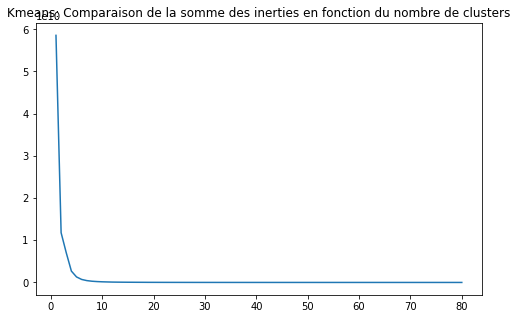

In [66]:
plt.figure(figsize=(8,5))
plt.title('Kmeans: Comparaison de la somme des inerties en fonction du nombre de clusters')
sns.lineplot(list(inertia.keys()),
             list(inertia.values())
            )

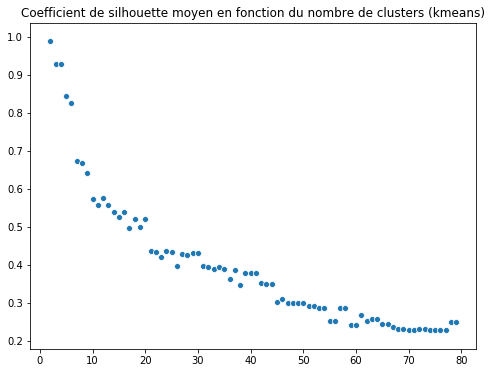

In [67]:

silhouettes_kmeans = {}
for i in range(2,max_clusters):
    silhouettes_kmeans[i] = silhouette_score(X = X_combined,
                                             labels= list(dict_kmeans[i].labels_))

plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
sns.scatterplot(x = list(silhouettes_kmeans.keys()),
               y = list(silhouettes_kmeans.values()))
plt.show()



In [68]:
for key, value in silhouettes_kmeans.items():
    if value == max(silhouettes_kmeans.values()):
        print('le coefficient de silhouette est maximal pour {} clusters (score = {})'.format(key, value))
        nb_clusters = key

le coefficient de silhouette est maximal pour 2 clusters (score = 0.9882808867943341)


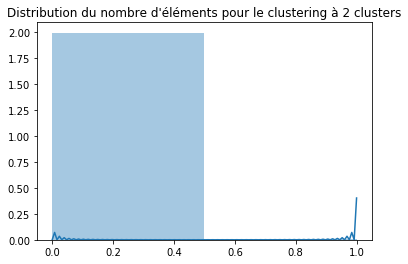

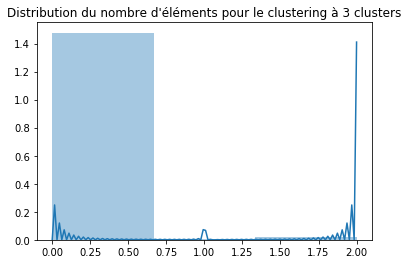

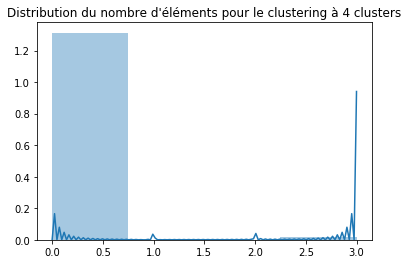

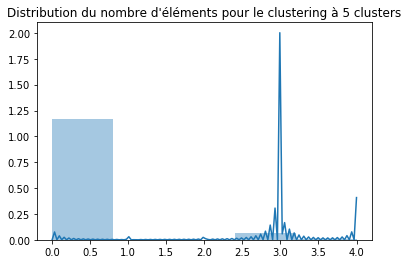

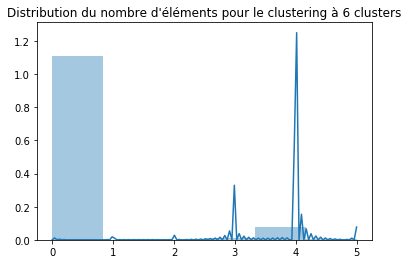

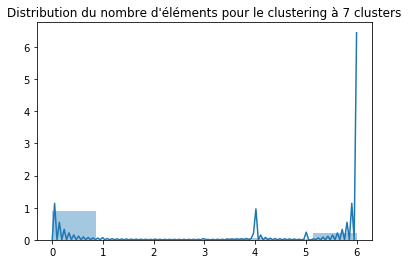

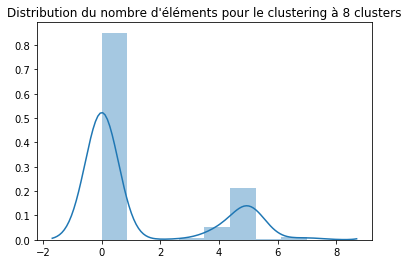

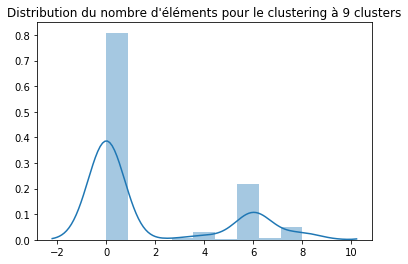

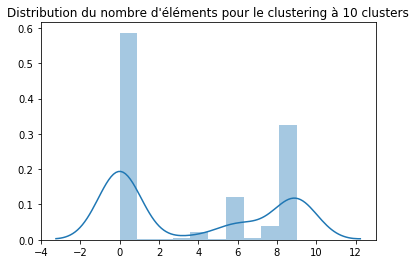

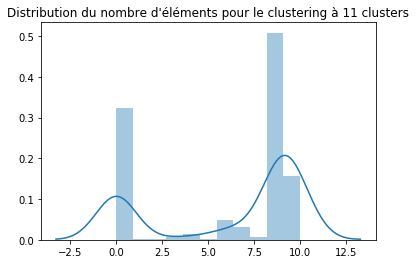

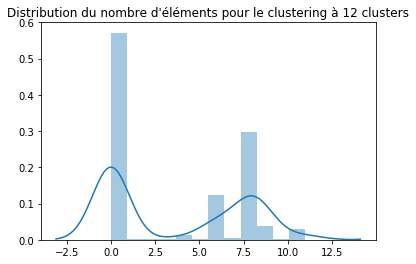

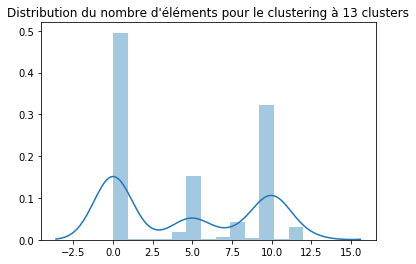

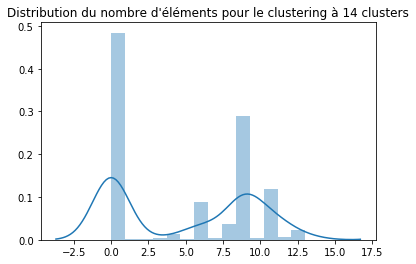

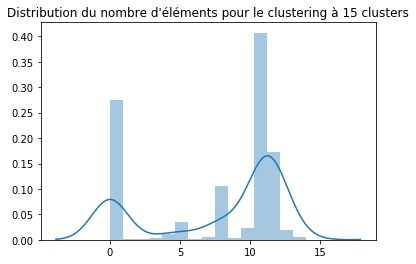

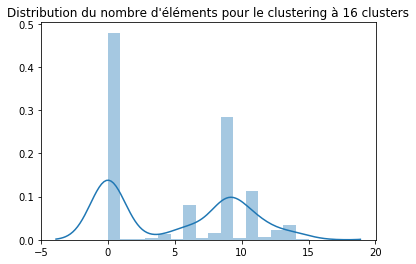

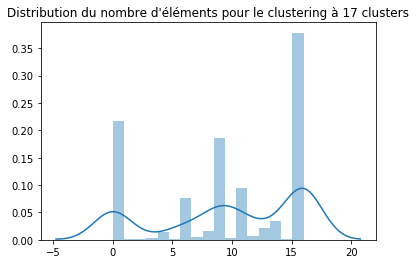

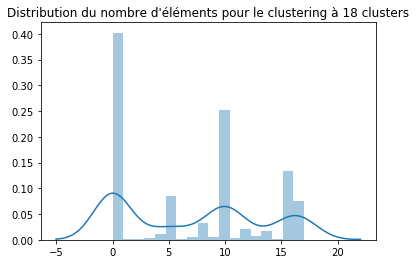

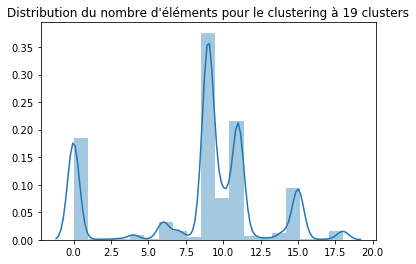

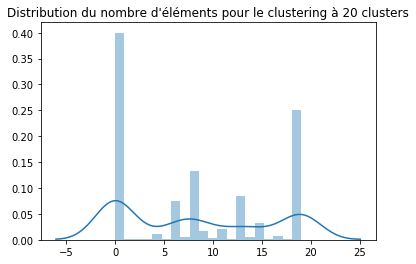

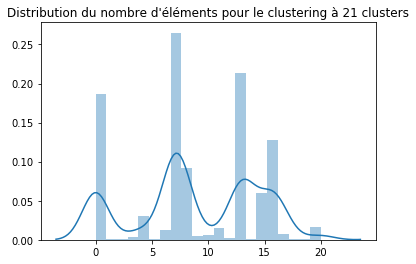

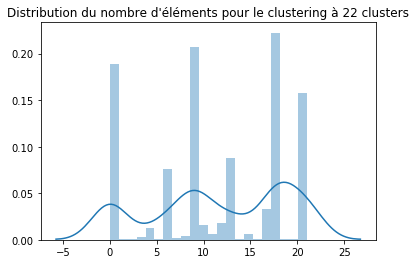

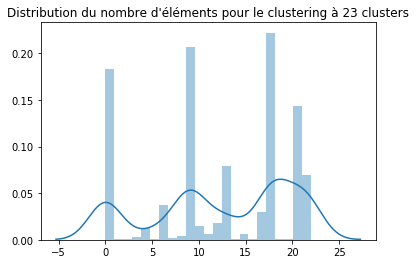

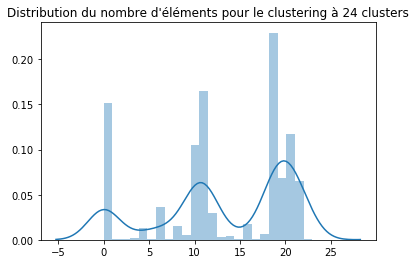

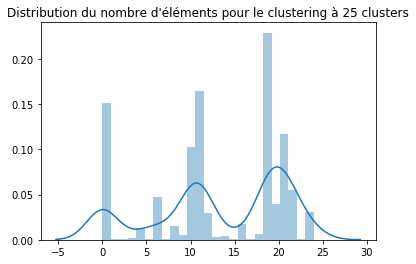

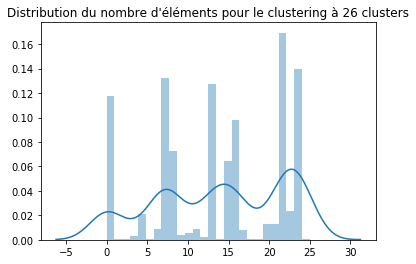

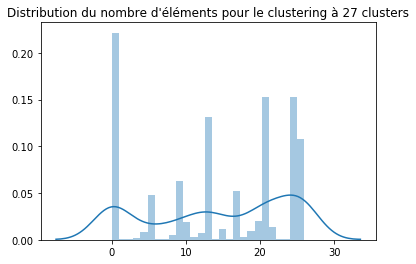

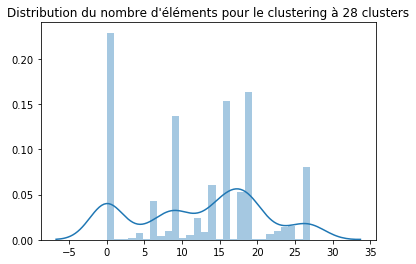

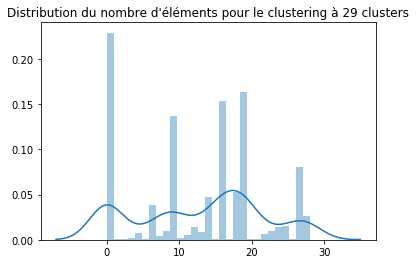

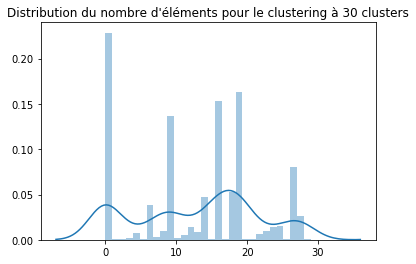

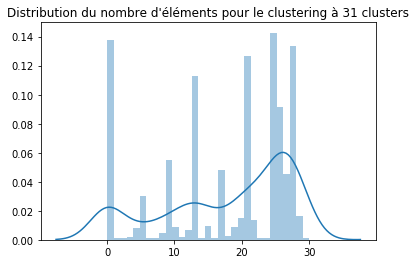

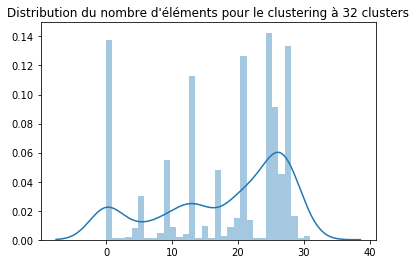

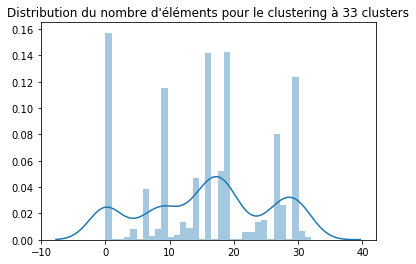

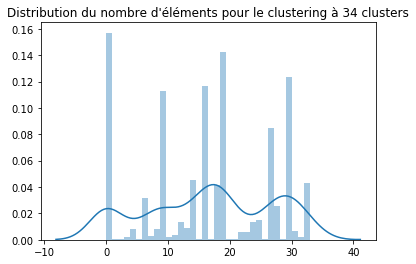

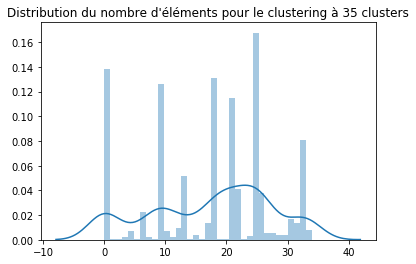

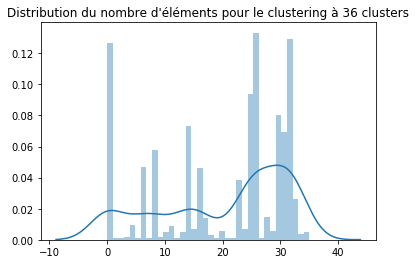

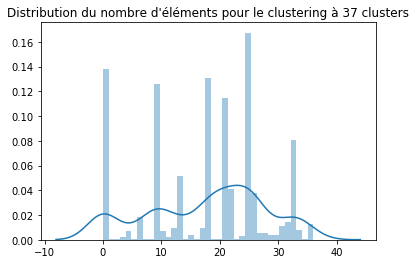

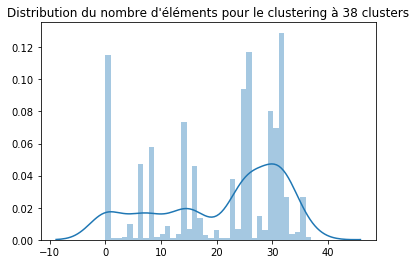

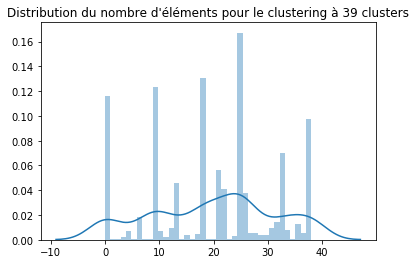

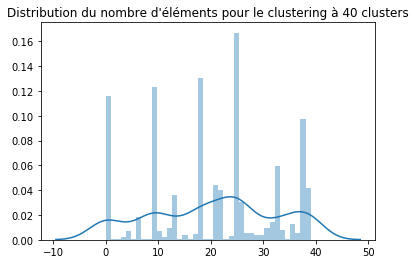

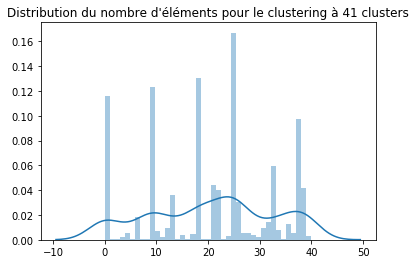

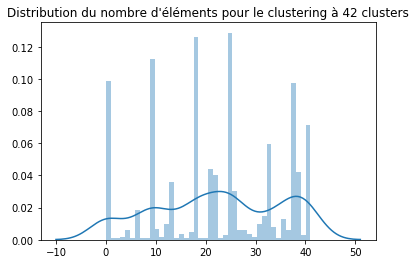

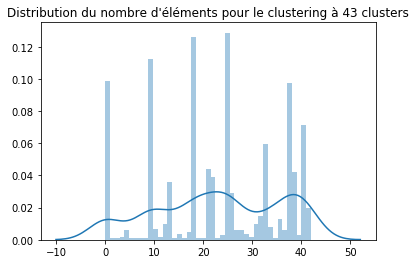

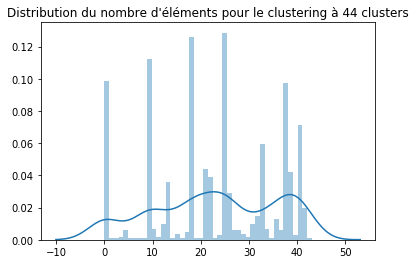

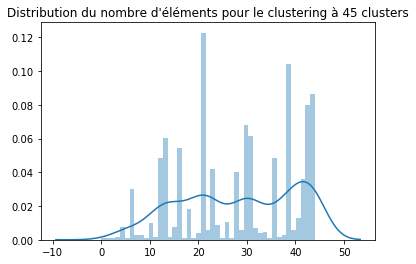

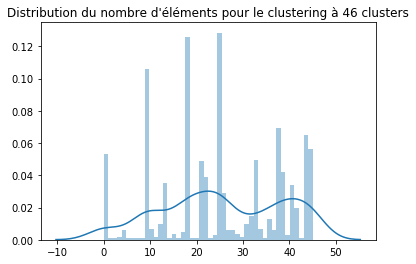

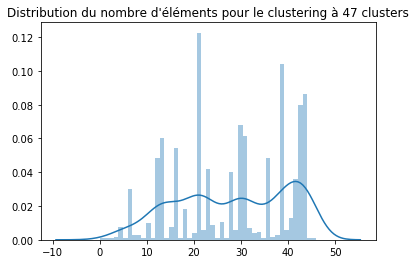

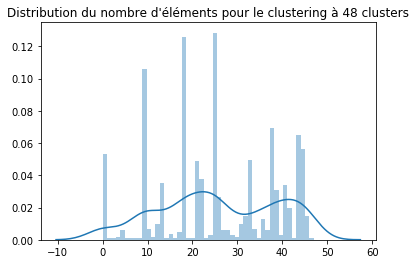

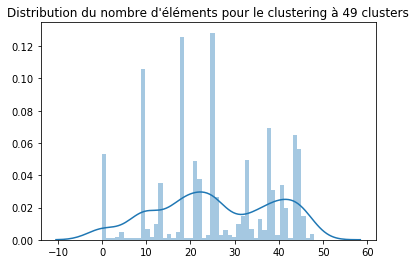

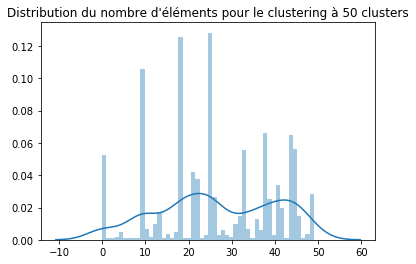

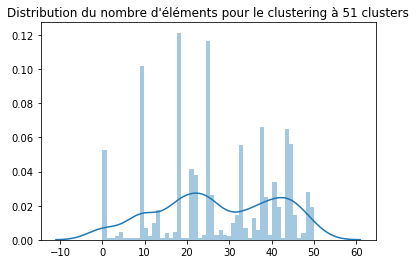

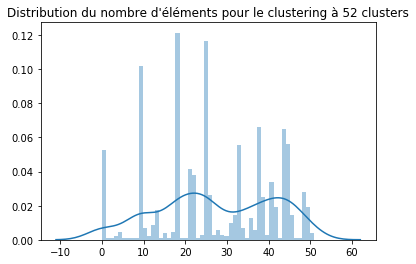

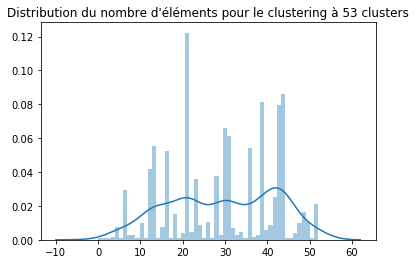

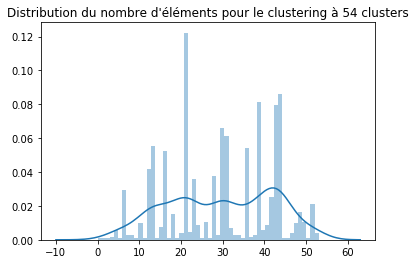

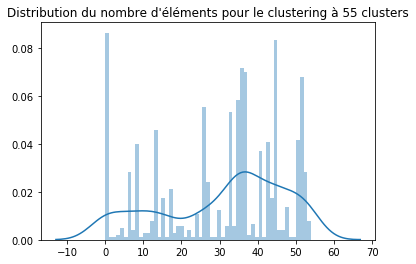

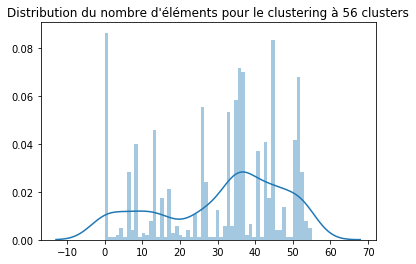

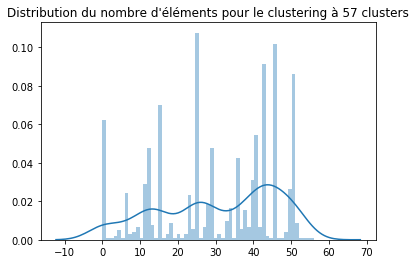

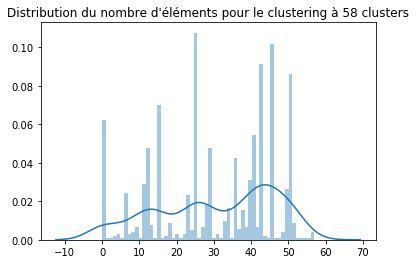

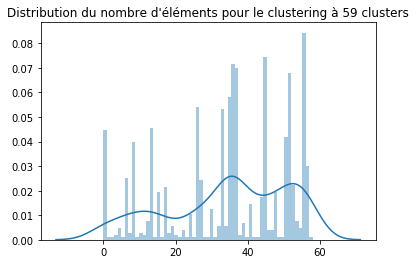

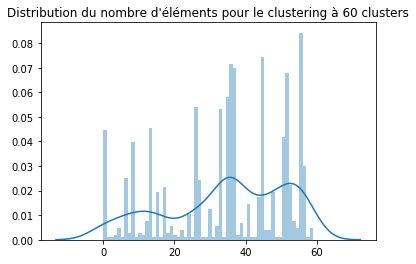

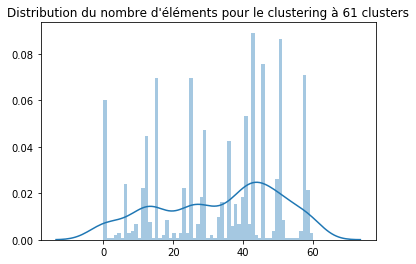

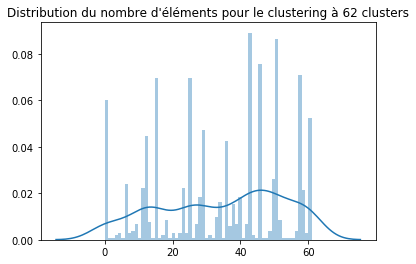

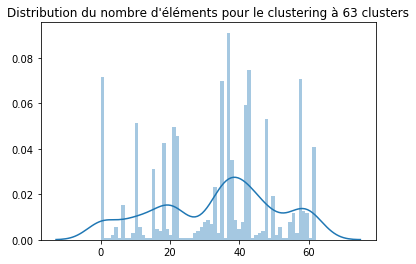

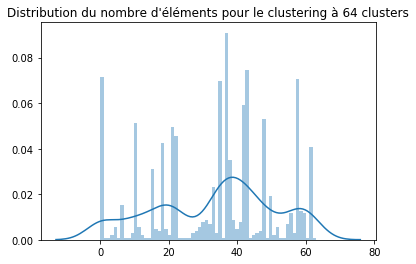

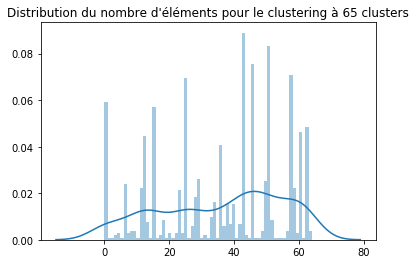

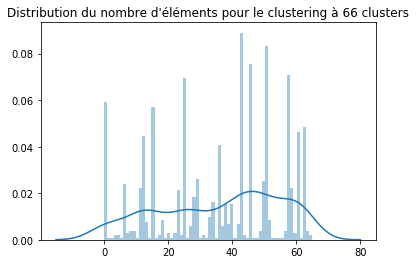

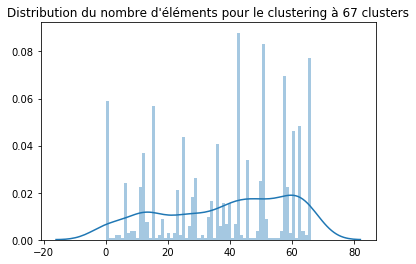

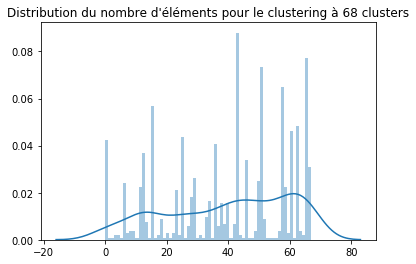

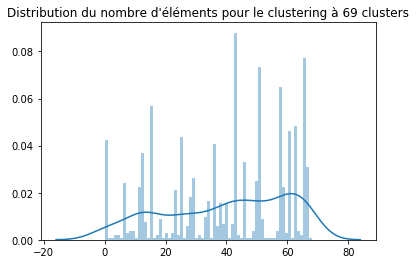

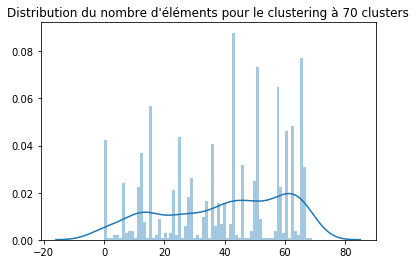

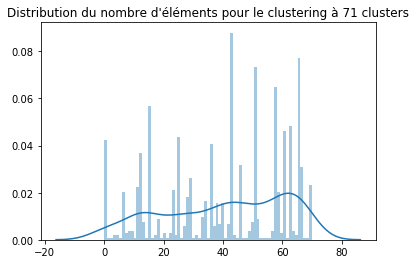

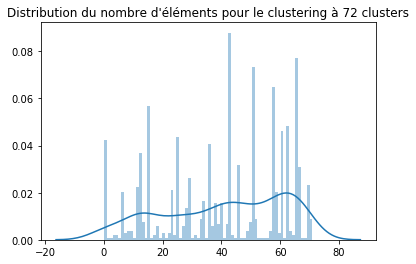

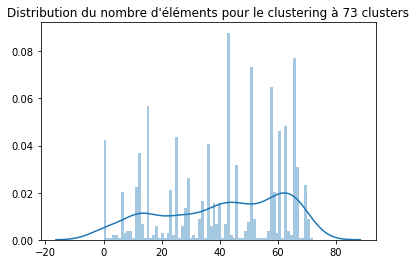

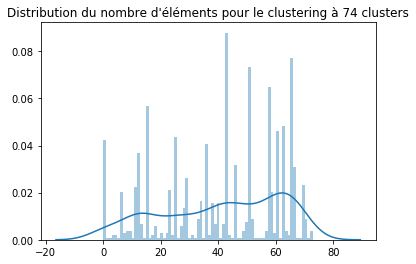

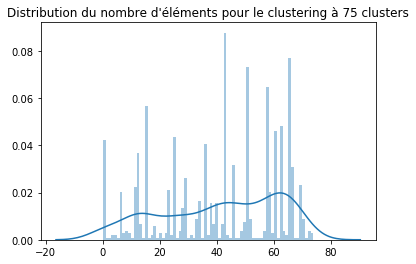

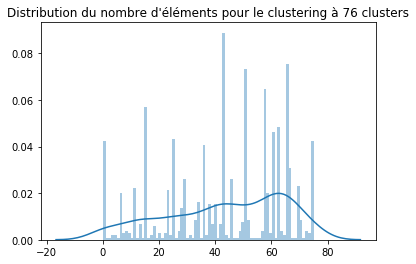

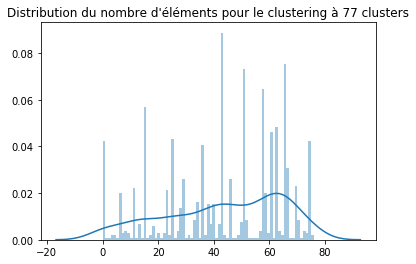

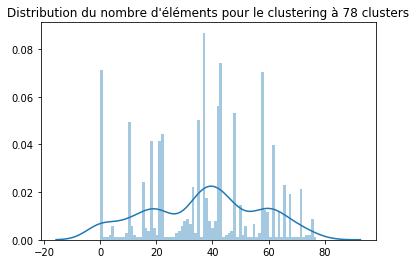

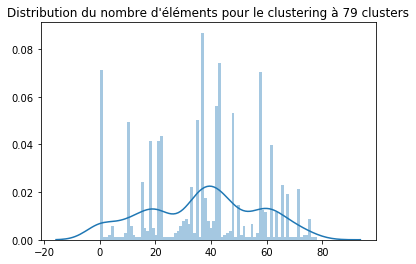

In [69]:
%matplotlib inline
for i in range(2,max_clusters):
    plt.figure()
    titre = 'Distribution du nombre d\'éléments pour le clustering à '+ str(i)+ ' clusters'
    plt.title(titre)
    sns.distplot(dict_kmeans[i].labels_, bins=i)
    plt.show()

Prenons le Kmeans avec 18 clusters

In [81]:
jeu_categoriel = pd.DataFrame(X_NLP)
jeu_categoriel['label'] = dict_kmeans[10].labels_

In [82]:
jeu_categoriel.to_csv('data_saved/jeu_complet_kmeans.csv')

In [83]:
jeu_categoriel.shape

(1050, 393)

## Représentation des données

In [84]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
T = tsne.fit_transform(X_combined.copy())

<Axes: title={'center': 'Représentation du jeu de données via T-SNE'}>

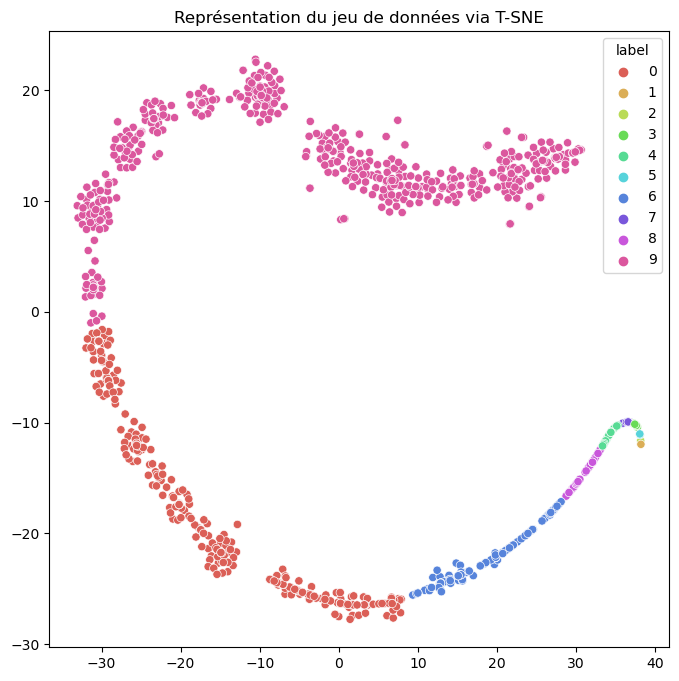

In [72]:
plt.figure(figsize=(8,8))
plt.title('Représentation du jeu de données via T-SNE')
palette_sns = sns.color_palette("hls", jeu_categoriel['label'].nunique())
sns.scatterplot(x= T[:,0], 
                y= T[:,1], 
                hue= jeu_categoriel['label'], 
                palette= palette_sns)

In [73]:
T.shape

(1050, 2)

In [74]:
X_combined.shape

(1050, 456)

In [75]:
data_final = pd.concat([train, test])
data_final['X_TSNE'] = T[:,0]
data_final['Y_TSNE'] = T[:,1]

In [76]:
data_final.set_index('Unnamed: 0', inplace=True)

In [77]:
data_final['label'] = jeu_categoriel['label'].tolist()

In [78]:
data_final.shape

(1050, 20)

In [79]:
data_final.to_csv('data_saved/data_final.csv')

In [80]:
data_final.head()

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cat_lvl_1,cat_lvl_2,cat_lvl_3,X_TSNE,Y_TSNE,label
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
165,785b4383b12106dd172306d427d8f7b2,2015-12-01 12:40:44 +0000,http://www.flipkart.com/rockmantra-cute-two-ca...,Rockmantra Cute Two Cats Ceramic Mug,MUGEAGGKFBTYPN4Z,499.0,349.0,785b4383b12106dd172306d427d8f7b2.jpg,False,Rockmantra Cute Two Cats Ceramic Mug (5.5 l)\r...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va...",Kitchen & Dining,Coffee Mugs,Rockmantra Coffee Mugs,-19.910641,-17.716896,0
248,45d0af2c709de47268c80c35a117de44,2015-12-01 12:40:44 +0000,http://www.flipkart.com/malhar-niko-male-doll-...,Malhar Niko Male Doll Showpiece - 25 cm,SHIEY382SR75SXEY,6395.0,5436.0,45d0af2c709de47268c80c35a117de44.jpg,True,Buy Malhar Niko Male Doll Showpiece - 25 cm ...,No rating available,No rating available,Malhar,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Decor & Festive Needs,Showpieces,Malhar Showpieces,-16.189047,18.369432,9
310,64b463dc0b75ae40a848498c657041e6,2015-12-01 06:13:00 +0000,http://www.flipkart.com/linksys-smart-wi-fi-ro...,Linksys Smart Wi-Fi Router,RTRDZTF9DBT4CW8U,14999.0,13500.0,64b463dc0b75ae40a848498c657041e6.jpg,True,Buy Linksys Smart Wi-Fi Router only for Rs. 0....,No rating available,No rating available,Linksys,"{""product_specification""=>[{""key""=>""Encryption...",Computers,Network Components,Routers,30.623508,14.635627,9
685,6b5cdfe68595fbcab0e05dc625d3d66a,2015-12-31 09:19:31 +0000,http://www.flipkart.com/richfeel-sunshield-spf...,Richfeel Sunshield - SPF 30 PA++,SNRE4F2GBWVF6UKR,299.0,224.0,6b5cdfe68595fbcab0e05dc625d3d66a.jpg,False,Flipkart.com: Buy Richfeel Sunshield - SPF 30 ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Quantity"",...",Beauty and Personal Care,Body and Skin Care,Face Care,0.160292,-26.339520,0
843,e86daf9ebcdfc5c5dd088cdb7f8f8db6,2015-12-29 05:07:38 +0000,http://www.flipkart.com/epresent-mfan-1-fan-us...,Epresent Mfan 1 Fan USB USB Fan,USGEB3HTYWCYT2HY,269.0,219.0,e86daf9ebcdfc5c5dd088cdb7f8f8db6.jpg,False,Buy Epresent Mfan 1 Fan USB USB Fan for Rs.219...,No rating available,No rating available,Epresent,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Computers,Laptop Accessories,USB Gadgets,-30.350624,-2.540635,0
